# Телеком

Оператор связи «ТелеДом» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах. 

**Описание услуг**

Оператор предоставляет два основных типа услуг: 
1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию DSL (от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
1. Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
2. Выделенная линия технической поддержки (TechSupport);
3. Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
4. Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных**

Данные хранятся в таблицах в базе данных PostgreSQL:

**contract** — информация о договоре,

**personal** — персональные данные клиента,

**internet** — информация об интернет-услугах,

**phone** — информация об услугах телефонии.

**Таблица telecom.contract**
* customerID — ID пользователя,
* BeginDate — дата начала действия,
* EndDate — дата окончания действия,
* Type — тип оплаты (раз в год или помесячно),
* PaperlessBilling — безбумажный расчётный лист,
* PaymentMethod — тип платежа,
* MonthlyCharges — расход за месяц,
* TotalCharges — общие расходы.

**Таблица telecom.personal**
* customerID — ID пользователя,
* gender — пол,
* SeniorCitizen — является ли абонент пенсионером,
* Partner — есть ли у абонента супруг/супруга,
* Dependents — есть ли у абонента дети.

**Таблица telecom.internet**
* customerID — ID пользователя,
* InternetService — тип подключения,
* OnlineSecurity — блокировка небезопасных сайтов,
* OnlineBackup — облачное хранилище файлов для резервного копирования данных,
* DeviceProtection — антивирус,
* TechSupport — выделенная линия технической поддержки,
* StreamingTV — стриминговое телевидение,
* StreamingMovies — каталог фильмов.

**Таблица telecom.phone**
* customerID — ID пользователя,
* MultipleLines — подключение телефонного аппарата к нескольким линиям одновременно.

## Загрузка данных

In [1]:
pip install sqlalchemy-utils >> None

In [2]:
pip install optuna >> None

In [3]:
pip install catboost >> None

In [4]:
pip install phik >> None

In [5]:
import numpy as np
import pandas as pd
import optuna
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

import phik
from phik.report import plot_correlation_matrix
from phik import report

import catboost as cb
from catboost import CatBoostClassifier

import sklearn.metrics
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import auc, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import datetime
from datetime import timedelta

from sqlalchemy import create_engine

from tqdm import tqdm

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Подключение к базе. 
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-final' # название базы данных,
} 
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [7]:
# Создание подключения:
engine = create_engine(connection_string) 

In [8]:
# выгрузим первую таблицу telecom.contract
#напишем запрос
query = '''
SELECT *
FROM telecom.contract
'''
#выполняем запрос
df_contract = pd.read_sql_query(query, con=engine)
display(df_contract.head())
df_contract.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


In [9]:
# выгрузим вторую таблицу personal
#напишем запрос
query = '''
SELECT *
FROM telecom.personal
'''
#выполняем запрос
df_personal = pd.read_sql_query(query, con=engine)
display(df_personal.head())
df_personal.info()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [10]:
# выгрузим третью таблицу telecom.internet
#напишем запрос
query = '''
SELECT *
FROM telecom.internet
'''
#выполняем запрос
df_internet = pd.read_sql_query(query, con=engine)
display(df_internet.head())
df_internet.info()

,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5518 entries, 0 to 5517
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      5518 non-null   object
 1   c2      5518 non-null   object
 2   c3      5518 non-null   object
 3   c4      5518 non-null   object
 4   c5      5518 non-null   object
 5   c6      5518 non-null   object
 6   c7      5518 non-null   object
 7   c8      5518 non-null   object
dtypes: object(8)
memory usage: 345.0+ KB


In [11]:
# выгрузим четвертую таблицу telecom.phone
#напишем запрос
query = '''
SELECT *
FROM telecom.phone
'''
#выполняем запрос
df_phone = pd.read_sql_query(query, con=engine)
display(df_phone.head(5))
df_phone.info()

,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362 entries, 0 to 6361
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      6362 non-null   object
 1   c2      6362 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


В таблицах df_internet и df_phone смещены названия столбцов, исправим это.


In [12]:
df_internet.columns=['customerID', 'InternetService', 'OnlineSecurity',	'OnlineBackup',	'DeviceProtection',	'TechSupport',	'StreamingTV',	'StreamingMovies']


In [13]:
df_phone.columns=['customerID',	'MultipleLines']

In [14]:
# удаляем первые строки
df_internet = df_internet.iloc[1:]
df_phone = df_phone.iloc[1:]

**Первичное исследование таблиц**

При первичном исследовании таблиц можно сказать, что:

- количество таблиц соответствует условию задачи;
- все таблицы имеют заявленный в описании набор данных, но telecom.contract содерджит пропуски;
- имеется общий ключ customerID для связи всех 4 таблиц.

## Исследовательский анализ данных

1. Сравним распределения величин ежемесячных платежей (MonthlyCharges) всех действующих клиентов и тех, кто ушёл. Для каждой группы посчитаем статистические показатели: средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей. Построим гистограммы распределения.

In [15]:
# выгрузим данные по ежемесячным платежам ушедших клиентов
#напишем запрос
query = '''
SELECT "MonthlyCharges"
FROM telecom.contract
WHERE "EndDate" IS NOT NULL
'''
#выполняем запрос
df_Monthly_gone = pd.read_sql_query(query, con=engine)

In [16]:
# выгрузим данные по ежемесячным платежам всех действующих клиентов
#напишем запрос
query = '''
SELECT "MonthlyCharges"
FROM telecom.contract
WHERE "EndDate" IS NULL
'''
#выполняем запрос
df_Monthly_current_clients = pd.read_sql_query(query, con=engine)

In [17]:
df_clients_MonthlyCharges = pd.concat([df_Monthly_gone, df_Monthly_current_clients], axis=1)   

In [18]:
df_clients_MonthlyCharges.columns=['gone_clients', 'current_clients']

In [19]:
df_clients_MonthlyCharges.head()

,gone_clients,current_clients
0,53.85,52.55
1,70.70,20.25
2,99.65,80.85
3,104.80,25.75
4,103.70,56.05


In [20]:
df_clients_MonthlyCharges.describe()

,gone_clients,current_clients
count,1869.000000,5174.000000
mean,74.441332,61.265124
std,24.666053,31.092648
min,18.850000,18.250000
25%,56.150000,25.100000
50%,79.650000,64.425000
75%,94.200000,88.400000
max,118.350000,118.750000


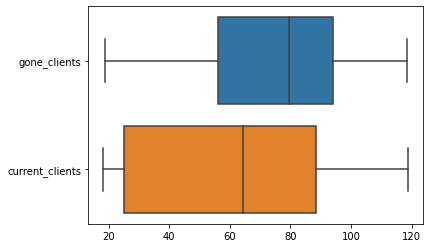

In [21]:
sns.boxplot(data=df_clients_MonthlyCharges, orient='h');

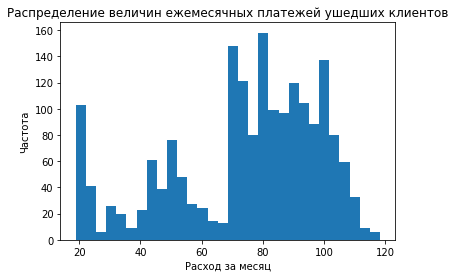

In [22]:
plt.hist(df_Monthly_gone.MonthlyCharges, density=False, bins=30) 
plt.ylabel('Частота')
plt.xlabel('Расход за месяц')
plt.title('Распределение величин ежемесячных платежей ушедших клиентов');

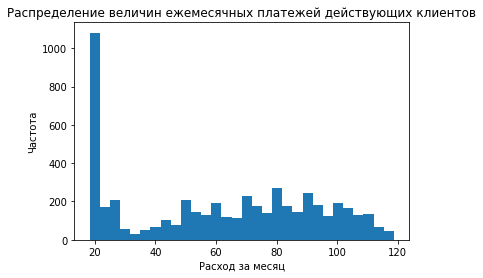

In [23]:
plt.hist(df_Monthly_current_clients.MonthlyCharges, density=False, bins=30) 
plt.ylabel('Частота')
plt.xlabel('Расход за месяц')
plt.title('Распределение величин ежемесячных платежей действующих клиентов');

*Вывод*
* Количество ушедших клиентов составило 26,5% от общего количества.
* В целом у ушедших клиентов ежемесячные траты были выше, нежели у оставшихся клиентов. 
* Также стоит отметить, что у четверти действующих клиентов расход составляет до 25 в месяц, что в 2 раза ниже, чем у аналогичной доли ушедших клиентов.


2. Сравним поведение клиентов этих двух групп. Для каждой построим два графика, отражающие:  
- долю пользователей телефонной связи,
- долю интернет-пользователей.

Посчитаем количество ушедших и оставшихся клиентов, пользующихся телефонной связью и интернетом.

In [24]:
# создадим датафрейм всех пользователей телефонной связью
df_phone_part = df_contract.merge(df_phone, how = 'outer', left_on='customerID', right_on='customerID')   

In [25]:
df_phone_part = df_phone_part[['EndDate', 'MultipleLines']]

In [26]:
df_phone_part.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   EndDate        1869 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 165.1+ KB


In [27]:
# ушедшие клиенты
phone_count_gone = len(df_phone_part.dropna())

In [28]:
# действующие клиенты
phone_count_current = len(df_phone_part[['MultipleLines']].dropna()) - phone_count_gone

In [29]:
# создадим датафрейм всех пользователей интернетом
df_internet_part = df_contract.merge(df_internet, how = 'outer', left_on='customerID', right_on='customerID') 

In [30]:
df_internet_part = df_internet_part[['EndDate', 'InternetService']]

In [31]:
df_internet_part.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   EndDate          1869 non-null   object
 1   InternetService  5517 non-null   object
dtypes: object(2)
memory usage: 165.1+ KB


In [32]:
# ушедшие клиенты
internet_count_gone = len(df_internet_part.dropna())

In [33]:
# действующие клиенты
internet_count_current = len(df_internet_part[['InternetService']].dropna()) - internet_count_gone

Для проведения анализа построим новый датафрейм.

In [34]:
df_part_users = pd.DataFrame({
    'gone_users': [internet_count_gone, phone_count_gone],
    'current_users': [internet_count_current, phone_count_current],
    'total_count': [len(df_internet_part[['InternetService']].dropna()), len(df_phone_part[['MultipleLines']].dropna())]},
    index = ['internet', 'phone']
).reset_index()

In [35]:
df_part_users.columns = ['service', 'gone_users', 'current_users', 'total_count']
df_part_users

,service,gone_users,current_users,total_count
0,internet,1756,3761,5517
1,phone,1699,4662,6361


Построим графики отражающие доли ушедших клиентов

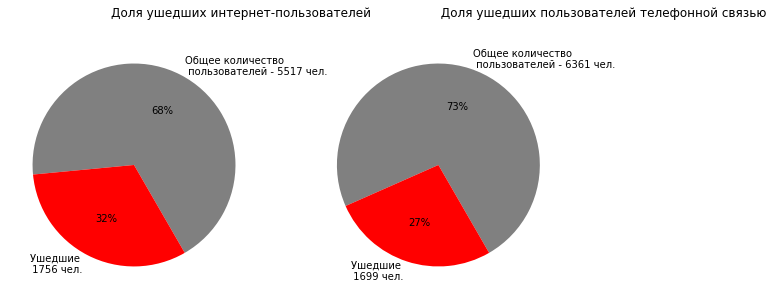

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))

slices = [len(df_internet_part[['InternetService']].dropna())-internet_count_gone, internet_count_gone]
colors = ['grey', 'red']
labels = 'Общее количество \n пользователей - 5517 чел.', 'Ушедшие \n 1756 чел.'
ax1.pie(slices, autopct='%1.0f%%', colors=colors, labels=labels, startangle=300)
plt.title('Доля ушедших интернет-пользователей                  Доля ушедших пользователей телефонной связью\n')

slices = [len(df_phone_part[['MultipleLines']].dropna())-phone_count_gone, phone_count_gone]
colors = ['grey', 'red']
labels = 'Общее количество \n пользователей - 6361 чел.', 'Ушедшие \n 1699 чел.'
ax2.pie(slices, autopct='%1.0f%%', colors=colors, labels=labels, startangle=300)
plt.show()

Из 5517 интернет-пользователей ушли 32% - 1756 чел.

Из 6361 пользователей телефонной связью ушли 27% - 1699 чел. 

Построим графики отражающие доли действующих клиентов

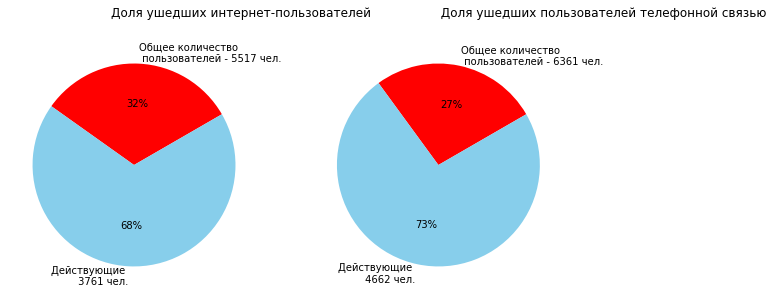

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))

slices = [len(df_internet_part[['InternetService']].dropna())-internet_count_current, internet_count_current]
colors = ['red', 'skyblue']
labels = 'Общее количество \n пользователей - 5517 чел.', 'Действующие \n 3761 чел.'
ax1.pie(slices, autopct='%1.0f%%', colors=colors, labels=labels, startangle=30)
plt.title('Доля ушедших интернет-пользователей                  Доля ушедших пользователей телефонной связью\n')

slices = [len(df_phone_part[['MultipleLines']].dropna())-phone_count_current, phone_count_current]
colors = ['red', 'skyblue']
labels = 'Общее количество \n пользователей - 6361 чел.', 'Действующие \n 4662 чел.'
ax2.pie(slices, autopct='%1.0f%%', colors=colors, labels=labels, startangle=30)
plt.show()

Из 5517 интернет-пользователей действующих 68% - 3761 чел.

Из 6361 пользователей телефонной связью действующих 73% - 4662 чел.

**Вывод**
* Количество ушедших клиентов составило 1869 чел - 26,5% от общего количества - 7043 чел.   
* В целом у ушедших клиентов ежемесячные траты были выше, нежели у оставшихся клиентов. 
* Также стоит отметить, что у четверти действующих клиентов расход составляет до 25 у.е. в месяц, что в 2 раза ниже, чем у аналогичной доли ушедших клиентов.
* Из 5517 интернет-пользователей ушли 32% - 1756 чел., действующих клиентов - 68% - 3761 чел.
* Из 6361 пользователей телефонной связью ушли 27% - 1699 чел., действующих клиентов - 73% - 4662 чел.

## Предобработка данных

In [38]:
# объединим датасеты в общий датасет
df = df_contract.merge(df_personal, how = 'outer', left_on='customerID', right_on='customerID')
df = df.merge(df_internet, how = 'outer', left_on='customerID', right_on='customerID')
df = df.merge(df_phone, how = 'outer', left_on='customerID', right_on='customerID')

In [39]:
df.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No


Добавим столбец с данными LTV - прибыль компании, полученная от одного клиента за всё время сотрудничества с ним.

In [40]:
df_ltv = df[['customerID', 'BeginDate', 'EndDate', 'Type', 'MonthlyCharges']]

In [41]:
df_ltv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   customerID      7043 non-null   object 
 1   BeginDate       7043 non-null   object 
 2   EndDate         1869 non-null   object 
 3   Type            7043 non-null   object 
 4   MonthlyCharges  7043 non-null   float64
dtypes: float64(1), object(4)
memory usage: 330.1+ KB


Так как у нас данные на 1 февраля 2020 года, то в столбце EndDate None в строках со значением Month-to-month в столбце Type заменим на 1 февраля 2020 года.

В остальных None заменим на время, которое указано в договоре. Затем вычислим общий интервал пользования услугами компании и рассчитаем какую прибыль принес каждый клиент.

In [42]:
df_ltv_1 = df_ltv[df_ltv['Type'] == 'Month-to-month']

In [43]:
df_ltv_2 = df_ltv[df_ltv['Type'] == 'Two year']

In [44]:
df_ltv_3 = df_ltv[df_ltv['Type'] == 'One year']

In [45]:
df_ltv_1['EndDate'] = df_ltv_1['EndDate'].fillna(value=np.nan)
df_ltv_1['EndDate'] = df_ltv_1['EndDate'].fillna('2020-02-01') 

In [46]:
df_ltv_2['EndDate'] = df_ltv_2['EndDate'].fillna(value=np.nan)
df_ltv_2['EndDate'] = df_ltv_2['EndDate'].fillna(pd.to_datetime(df_ltv_2['BeginDate']) + timedelta(days=365*2)) 

In [47]:
df_ltv_3['EndDate'] = df_ltv_3['EndDate'].fillna(value=np.nan)
df_ltv_3['EndDate'] = df_ltv_3['EndDate'].fillna(pd.to_datetime(df_ltv_3['BeginDate']) + timedelta(days=365))

In [48]:
df_ltv = df_ltv_1.append(df_ltv_2)
df_ltv = df_ltv.append(df_ltv_3)

In [49]:
df_ltv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 2 to 7040
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   customerID      7043 non-null   object 
 1   BeginDate       7043 non-null   object 
 2   EndDate         7043 non-null   object 
 3   Type            7043 non-null   object 
 4   MonthlyCharges  7043 non-null   float64
dtypes: float64(1), object(4)
memory usage: 330.1+ KB


In [50]:
# переведем BeginDate, EndDate в тип datetime
df_ltv['BeginDate'] = pd.to_datetime(df_ltv['BeginDate']) 
df_ltv['EndDate'] = pd.to_datetime(df_ltv['EndDate']);

In [51]:
# какой период клиент пользовался услугами компании
df_ltv['all_time'] = df_ltv['EndDate'].dt.to_period('M').astype(int) - df_ltv['BeginDate'].dt.to_period('M').astype(int)

In [52]:
df_ltv.head(5)

,customerID,BeginDate,EndDate,Type,MonthlyCharges,all_time
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,53.85,16
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,70.70,10
5,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,99.65,11
8,7892-POOKP,2019-04-27,2019-11-01,Month-to-month,104.80,7
12,0280-XJGEX,2018-11-13,2019-10-01,Month-to-month,103.70,11


In [53]:
df_ltv['ltv'] = df_ltv['all_time'] * df_ltv['MonthlyCharges']

In [54]:
df_ltv = df_ltv[['customerID','ltv']]

In [55]:
df = df.merge(df_ltv, how = 'outer', left_on='customerID', right_on='customerID')

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Удалим столбцы, которые не понадобятся для дальнейшей работы:
* customerID
* PaperlessBilling и PaymentMethod - безбумажный расчётный лист, так как, вероятно, этот параметр гибкий, настраиваемый клиентом и не влияющий на желание продолжать пользоваться услугами компании.

In [57]:
df = df.drop(['customerID','PaymentMethod', 'PaperlessBilling'], axis=1)

В столбце EndDate расположена дата, если клиент расторг договор с компанией (т.е. ушедший клиент) и None, если не расторг договор. Сделаем значения в данном столбце 1 - клиент ушел, 0 - не ушел.

In [58]:
# переводим None в NaN, а потом заменяем 0
df['EndDate'] = df['EndDate'].replace(r'', np.NaN)
df['EndDate'] = df['EndDate'].fillna(0)

In [59]:
# остальные значения, которые не равны 0, заменяем 1
df['EndDate'] = np.where(df['EndDate'] != 0, 1, 0)

In [60]:
# проверяем все ли правильно получилось
df['EndDate'].value_counts()

0    5174
1    1869
Name: EndDate, dtype: int64

In [61]:
df_for_analys = df.copy()

Столбец gender для более быстрых вычислений также переведем в 0 - Male, 1 - Female	

In [62]:
df['gender'] = np.where(df['gender'] == 'Female', 1, 0)

Столбец BeginDate преобразуем в отдельные столбцы "год", "месяц", "день недели"

In [63]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'])  
df['year'] = df['BeginDate'].apply(lambda x: x.year)  
df['month'] = df['BeginDate'].apply(lambda x: x.month)  
df['weekday'] = df['BeginDate'].apply(lambda x: x.dayofweek)  

Удалим BeginDate, в первоначальном виде он нам уже не нужен

In [64]:
df = df.drop(['BeginDate'], axis=1)

Посмотрим на имеющиеся значения столбца Type и переведем значения в категориальные

In [65]:
df.Type.value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

In [66]:
df['Type'] = df['Type'].map({'Month-to-month': 0, 'One year': 1, 'Two year': 2})

In [67]:
df.InternetService.value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

Переведем значения Fiber optic в 1, DSL - 0:

In [68]:
df['InternetService'] = np.where(df['InternetService'] == 'Fiber optic', 1, 0)

Посмотрим на другие столбцы, в которых предположительно данные делятся на Yes и No переведем в 1 (Yes) и 0 (No).

In [69]:
def function_yes_or_no(df, list_columns):
    for i in list_columns:
        print(df[i].value_counts())

In [70]:
list_columns = ['SeniorCitizen', 'Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                     'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

In [71]:
function_yes_or_no(df, list_columns)

0    5901
1    1142
Name: SeniorCitizen, dtype: int64
No     3641
Yes    3402
Name: Partner, dtype: int64
No     4933
Yes    2110
Name: Dependents, dtype: int64
No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64
No     3088
Yes    2429
Name: OnlineBackup, dtype: int64
No     3095
Yes    2422
Name: DeviceProtection, dtype: int64
No     3473
Yes    2044
Name: TechSupport, dtype: int64
No     2810
Yes    2707
Name: StreamingTV, dtype: int64
No     2785
Yes    2732
Name: StreamingMovies, dtype: int64
No     3390
Yes    2971
Name: MultipleLines, dtype: int64


In [72]:
def function_0_or_1(df, list_columns):
    for i in list_columns:
        df[i] = np.where(df[i] == 'Yes', 1, 0)
    return df

In [73]:
df = function_0_or_1(df, list_columns)

Пропуски (кроме столбца TotalCharges) заполнились 0. Это нас устраивает, так как показывает, что клиент этой услугой не пользовался.

Теперь удалим строки, где есть пропуски в столбце TotalCharges. Их всего 11.

In [74]:
df = df.dropna()

Проверим наличие выбросов в столбцах MonthlyCharges, TotalCharges

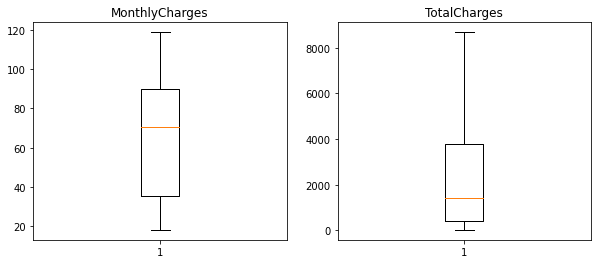

In [75]:
fig, ax = plt.subplots(figsize=(10,4), nrows=1, ncols=2)
ax[0].boxplot(df['MonthlyCharges'])
ax[0].set_title('MonthlyCharges')
ax[1].boxplot(df['TotalCharges'])
ax[1].set_title('TotalCharges');

Выбросов нет. Данные готовы к следующему этапу.

Посмотрим на Phik корреляцию признаков 

In [76]:
interval_cols = df.columns
phik_overview = df.phik_matrix(interval_cols=interval_cols)

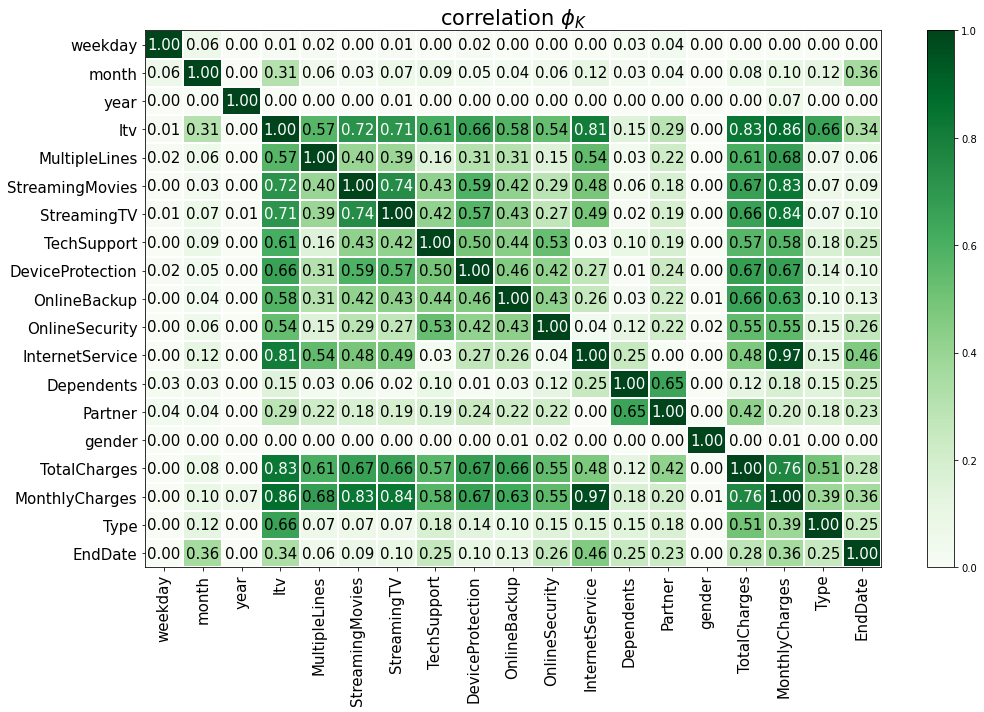

In [77]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(15, 10))
plt.tight_layout()

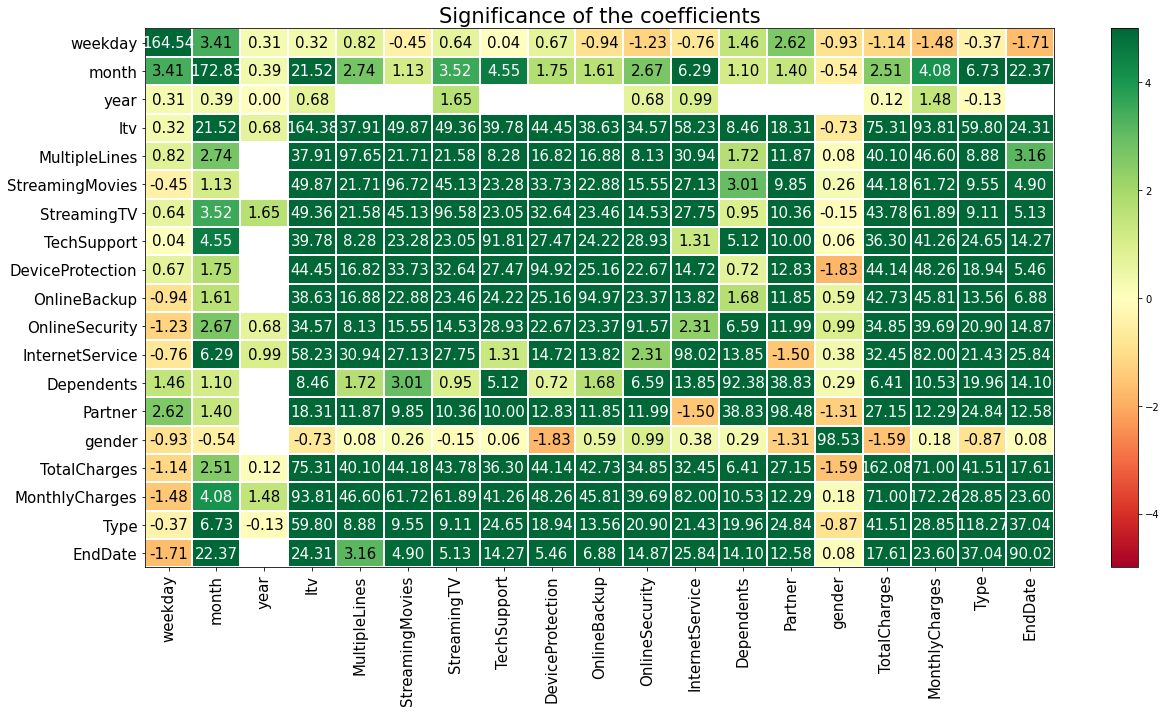

In [78]:
significance_overview = df.significance_matrix(interval_cols=interval_cols)
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1.5, figsize=(18, 10))
plt.tight_layout()

Исходя из данных корреляции Phik и значимости полученных значений, удалим признаки, которые имеют корреляцию меньше 0.2 и не значимы для обучения моделей.
Удаляем столбцы: weekday, year, gender.

In [79]:
df = df.drop(columns=['weekday', 'gender', 'year'], axis=1)

## Подготовка обучающей, валидационной и тестовой выборок, масштабирование.

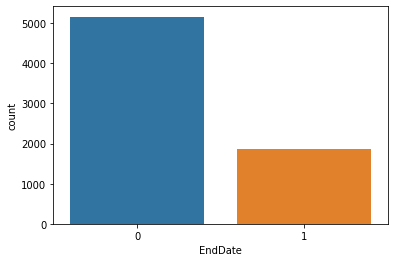

In [80]:
# проверим дисбаланс целевого признака
sns.countplot(x = 'EndDate', data = df);

Разница более, чем в 2 раза. Дисбаланс имеется. Учтем это при дальнейшей работе.

In [81]:
X = df.drop('EndDate', axis=1)
y = df['EndDate']

In [82]:
X_train_1, X_test_1, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) 

In [83]:
X_train_1, X_val_1, y_train, y_val = train_test_split(X_train_1, y_train, test_size = 0.2, random_state = 42) 

In [84]:
# Инициализация стандартизатора
scaler = StandardScaler()

# Передача датасета и преобразование
scaler.fit(X_train_1)
X_train = scaler.transform(X_train_1)
X_val = scaler.transform(X_val_1)
X_test = scaler.transform(X_test_1)

## Найдем лучшую модель

### CatBoost

In [85]:
def objective(trial):
    param_grid = {"n_estimators": trial.suggest_int('n_estimators', 300, 500, 50),
                  'max_depth': trial.suggest_int('max_depth', 1, 8, 1)}
    clf = cb.CatBoostClassifier(**param_grid, scale_pos_weight=2, random_state=42)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_val)
    probs = clf.predict_proba(X_val)[:,1]
 
    # Metrics
    accuracy = sklearn.metrics.accuracy_score(y_val, preds)
    roc_auc = sklearn.metrics.roc_auc_score(y_val, probs)

    return accuracy, roc_auc

In [86]:
study = optuna.create_study(directions=['maximize', 'maximize'])
study.optimize(objective, n_trials=10)

[I 2023-01-13 16:28:51,510] A new study created in memory with name: no-name-8c061d68-4a83-4423-ac0f-e6deb8aef566


Learning rate set to 0.05128
0:	learn: 0.6601064	total: 50.4ms	remaining: 17.6s
1:	learn: 0.6367261	total: 53.9ms	remaining: 9.38s
2:	learn: 0.6110537	total: 57.1ms	remaining: 6.61s
3:	learn: 0.5881948	total: 60.5ms	remaining: 5.23s
4:	learn: 0.5720513	total: 63.9ms	remaining: 4.41s
5:	learn: 0.5592225	total: 67.3ms	remaining: 3.86s
6:	learn: 0.5436234	total: 70.3ms	remaining: 3.44s
7:	learn: 0.5295428	total: 73.6ms	remaining: 3.14s
8:	learn: 0.5204293	total: 76.6ms	remaining: 2.9s
9:	learn: 0.5095884	total: 79.6ms	remaining: 2.7s
10:	learn: 0.5025923	total: 82.4ms	remaining: 2.54s
11:	learn: 0.4930095	total: 85.3ms	remaining: 2.4s
12:	learn: 0.4853592	total: 88.5ms	remaining: 2.29s
13:	learn: 0.4785149	total: 91.5ms	remaining: 2.2s
14:	learn: 0.4720197	total: 94.7ms	remaining: 2.12s
15:	learn: 0.4669866	total: 97.8ms	remaining: 2.04s
16:	learn: 0.4607353	total: 101ms	remaining: 1.97s
17:	learn: 0.4569477	total: 104ms	remaining: 1.92s
18:	learn: 0.4534509	total: 107ms	remaining: 1.86s


[I 2023-01-13 16:28:52,914] Trial 0 finished with values: [0.9271111111111111, 0.9707257762813318] and parameters: {'n_estimators': 350, 'max_depth': 6}. 


323:	learn: 0.1459753	total: 1.16s	remaining: 92.9ms
324:	learn: 0.1454815	total: 1.16s	remaining: 89.3ms
325:	learn: 0.1451002	total: 1.16s	remaining: 85.7ms
326:	learn: 0.1445682	total: 1.17s	remaining: 82.1ms
327:	learn: 0.1442812	total: 1.17s	remaining: 78.5ms
328:	learn: 0.1440468	total: 1.17s	remaining: 74.9ms
329:	learn: 0.1436693	total: 1.18s	remaining: 71.3ms
330:	learn: 0.1432590	total: 1.18s	remaining: 67.7ms
331:	learn: 0.1426775	total: 1.18s	remaining: 64.1ms
332:	learn: 0.1424673	total: 1.19s	remaining: 60.5ms
333:	learn: 0.1420146	total: 1.19s	remaining: 57ms
334:	learn: 0.1416125	total: 1.19s	remaining: 53.4ms
335:	learn: 0.1411292	total: 1.2s	remaining: 49.8ms
336:	learn: 0.1407813	total: 1.2s	remaining: 46.2ms
337:	learn: 0.1402230	total: 1.2s	remaining: 42.6ms
338:	learn: 0.1398615	total: 1.2s	remaining: 39.1ms
339:	learn: 0.1395827	total: 1.21s	remaining: 35.5ms
340:	learn: 0.1390927	total: 1.21s	remaining: 31.9ms
341:	learn: 0.1388001	total: 1.21s	remaining: 28.4ms

[I 2023-01-13 16:28:53,881] Trial 1 finished with values: [0.896, 0.9522926527757445] and parameters: {'n_estimators': 350, 'max_depth': 4}. 


338:	learn: 0.2304945	total: 819ms	remaining: 26.6ms
339:	learn: 0.2300443	total: 822ms	remaining: 24.2ms
340:	learn: 0.2298853	total: 824ms	remaining: 21.7ms
341:	learn: 0.2295362	total: 826ms	remaining: 19.3ms
342:	learn: 0.2294170	total: 828ms	remaining: 16.9ms
343:	learn: 0.2292133	total: 830ms	remaining: 14.5ms
344:	learn: 0.2290515	total: 832ms	remaining: 12.1ms
345:	learn: 0.2288249	total: 835ms	remaining: 9.65ms
346:	learn: 0.2286872	total: 837ms	remaining: 7.23ms
347:	learn: 0.2285396	total: 839ms	remaining: 4.82ms
348:	learn: 0.2283834	total: 841ms	remaining: 2.41ms
349:	learn: 0.2279764	total: 843ms	remaining: 0us
Learning rate set to 0.05128
0:	learn: 0.6793295	total: 1.28ms	remaining: 448ms
1:	learn: 0.6670708	total: 2.86ms	remaining: 498ms
2:	learn: 0.6562003	total: 4.37ms	remaining: 506ms
3:	learn: 0.6465900	total: 6.15ms	remaining: 532ms
4:	learn: 0.6380657	total: 7.78ms	remaining: 537ms
5:	learn: 0.6305113	total: 9.23ms	remaining: 529ms
6:	learn: 0.6247232	total: 10.7m

[I 2023-01-13 16:28:54,563] Trial 2 finished with values: [0.7706666666666667, 0.8609179557247189] and parameters: {'n_estimators': 350, 'max_depth': 1}. 


308:	learn: 0.4426058	total: 502ms	remaining: 66.6ms
309:	learn: 0.4424955	total: 510ms	remaining: 65.8ms
310:	learn: 0.4423967	total: 512ms	remaining: 64.1ms
311:	learn: 0.4422613	total: 513ms	remaining: 62.5ms
312:	learn: 0.4421480	total: 515ms	remaining: 60.9ms
313:	learn: 0.4420370	total: 516ms	remaining: 59.2ms
314:	learn: 0.4419356	total: 518ms	remaining: 57.6ms
315:	learn: 0.4418289	total: 520ms	remaining: 55.9ms
316:	learn: 0.4416937	total: 521ms	remaining: 54.3ms
317:	learn: 0.4416141	total: 523ms	remaining: 52.6ms
318:	learn: 0.4415180	total: 525ms	remaining: 51ms
319:	learn: 0.4414241	total: 526ms	remaining: 49.3ms
320:	learn: 0.4413207	total: 528ms	remaining: 47.7ms
321:	learn: 0.4412241	total: 529ms	remaining: 46ms
322:	learn: 0.4411152	total: 531ms	remaining: 44.4ms
323:	learn: 0.4409805	total: 533ms	remaining: 42.7ms
324:	learn: 0.4408776	total: 534ms	remaining: 41.1ms
325:	learn: 0.4407889	total: 536ms	remaining: 39.4ms
326:	learn: 0.4406936	total: 537ms	remaining: 37.8

[I 2023-01-13 16:28:55,576] Trial 3 finished with values: [0.8168888888888889, 0.8913246799720229] and parameters: {'n_estimators': 450, 'max_depth': 2}. 


417:	learn: 0.3794603	total: 806ms	remaining: 61.7ms
418:	learn: 0.3793131	total: 809ms	remaining: 59.8ms
419:	learn: 0.3791898	total: 814ms	remaining: 58.1ms
420:	learn: 0.3791065	total: 815ms	remaining: 56.2ms
421:	learn: 0.3789794	total: 817ms	remaining: 54.2ms
422:	learn: 0.3788588	total: 823ms	remaining: 52.5ms
423:	learn: 0.3787090	total: 825ms	remaining: 50.6ms
424:	learn: 0.3785760	total: 827ms	remaining: 48.6ms
425:	learn: 0.3784554	total: 828ms	remaining: 46.7ms
426:	learn: 0.3782292	total: 830ms	remaining: 44.7ms
427:	learn: 0.3779825	total: 832ms	remaining: 42.8ms
428:	learn: 0.3778529	total: 834ms	remaining: 40.8ms
429:	learn: 0.3777652	total: 835ms	remaining: 38.8ms
430:	learn: 0.3775087	total: 837ms	remaining: 36.9ms
431:	learn: 0.3774163	total: 839ms	remaining: 35ms
432:	learn: 0.3772986	total: 841ms	remaining: 33ms
433:	learn: 0.3772168	total: 842ms	remaining: 31.1ms
434:	learn: 0.3771292	total: 844ms	remaining: 29.1ms
435:	learn: 0.3769837	total: 845ms	remaining: 27.1

[I 2023-01-13 16:28:56,748] Trial 4 finished with values: [0.9262222222222222, 0.9705427869679077] and parameters: {'n_estimators': 300, 'max_depth': 6}. 


Learning rate set to 0.040725
0:	learn: 0.6791730	total: 1.59ms	remaining: 717ms
1:	learn: 0.6654936	total: 3.39ms	remaining: 760ms
2:	learn: 0.6531086	total: 5.1ms	remaining: 759ms
3:	learn: 0.6427820	total: 6.75ms	remaining: 753ms
4:	learn: 0.6333440	total: 8.45ms	remaining: 752ms
5:	learn: 0.6252843	total: 10.4ms	remaining: 768ms
6:	learn: 0.6167690	total: 12.1ms	remaining: 765ms
7:	learn: 0.6085589	total: 13.8ms	remaining: 764ms
8:	learn: 0.6016333	total: 15.5ms	remaining: 761ms
9:	learn: 0.5950441	total: 17.3ms	remaining: 761ms
10:	learn: 0.5891278	total: 19ms	remaining: 758ms
11:	learn: 0.5836322	total: 20.7ms	remaining: 756ms
12:	learn: 0.5782942	total: 22.4ms	remaining: 754ms
13:	learn: 0.5734629	total: 24.2ms	remaining: 753ms
14:	learn: 0.5697636	total: 25.9ms	remaining: 751ms
15:	learn: 0.5655072	total: 27.8ms	remaining: 754ms
16:	learn: 0.5614542	total: 29.7ms	remaining: 757ms
17:	learn: 0.5569525	total: 31.6ms	remaining: 758ms
18:	learn: 0.5530638	total: 33.5ms	remaining: 7

[I 2023-01-13 16:28:57,746] Trial 5 finished with values: [0.8168888888888889, 0.8913246799720229] and parameters: {'n_estimators': 450, 'max_depth': 2}. 


392:	learn: 0.3837207	total: 744ms	remaining: 108ms
393:	learn: 0.3835638	total: 746ms	remaining: 106ms
394:	learn: 0.3833893	total: 749ms	remaining: 104ms
395:	learn: 0.3833001	total: 751ms	remaining: 102ms
396:	learn: 0.3832111	total: 753ms	remaining: 101ms
397:	learn: 0.3829200	total: 755ms	remaining: 98.6ms
398:	learn: 0.3826523	total: 756ms	remaining: 96.7ms
399:	learn: 0.3824921	total: 758ms	remaining: 94.8ms
400:	learn: 0.3823666	total: 760ms	remaining: 92.8ms
401:	learn: 0.3822199	total: 762ms	remaining: 91ms
402:	learn: 0.3820661	total: 763ms	remaining: 89ms
403:	learn: 0.3819334	total: 765ms	remaining: 87.1ms
404:	learn: 0.3816629	total: 767ms	remaining: 85.2ms
405:	learn: 0.3814061	total: 769ms	remaining: 83.3ms
406:	learn: 0.3813020	total: 771ms	remaining: 81.4ms
407:	learn: 0.3810626	total: 772ms	remaining: 79.5ms
408:	learn: 0.3809009	total: 774ms	remaining: 77.6ms
409:	learn: 0.3807377	total: 776ms	remaining: 75.7ms
410:	learn: 0.3806418	total: 777ms	remaining: 73.8ms
41

[I 2023-01-13 16:28:58,569] Trial 6 finished with values: [0.8995555555555556, 0.9517355519770979] and parameters: {'n_estimators': 300, 'max_depth': 4}. 


257:	learn: 0.2452228	total: 610ms	remaining: 99.2ms
258:	learn: 0.2447187	total: 613ms	remaining: 97.1ms
259:	learn: 0.2442341	total: 615ms	remaining: 94.7ms
260:	learn: 0.2437118	total: 618ms	remaining: 92.3ms
261:	learn: 0.2431779	total: 620ms	remaining: 89.9ms
262:	learn: 0.2428186	total: 622ms	remaining: 87.6ms
263:	learn: 0.2426129	total: 625ms	remaining: 85.2ms
264:	learn: 0.2421262	total: 627ms	remaining: 82.8ms
265:	learn: 0.2417386	total: 629ms	remaining: 80.4ms
266:	learn: 0.2411151	total: 632ms	remaining: 78.2ms
267:	learn: 0.2406760	total: 635ms	remaining: 75.8ms
268:	learn: 0.2404152	total: 637ms	remaining: 73.4ms
269:	learn: 0.2402324	total: 639ms	remaining: 71ms
270:	learn: 0.2397003	total: 641ms	remaining: 68.6ms
271:	learn: 0.2390500	total: 645ms	remaining: 66.4ms
272:	learn: 0.2386353	total: 648ms	remaining: 64.1ms
273:	learn: 0.2382095	total: 651ms	remaining: 61.8ms
274:	learn: 0.2376627	total: 653ms	remaining: 59.4ms
275:	learn: 0.2373489	total: 655ms	remaining: 57

[I 2023-01-13 16:29:00,313] Trial 7 finished with values: [0.9288888888888889, 0.9708721677320711] and parameters: {'n_estimators': 450, 'max_depth': 6}. 


Learning rate set to 0.04537
0:	learn: 0.6637409	total: 3.3ms	remaining: 1.32s
1:	learn: 0.6425785	total: 6.57ms	remaining: 1.31s
2:	learn: 0.6190709	total: 9.53ms	remaining: 1.26s
3:	learn: 0.5978653	total: 12.6ms	remaining: 1.25s
4:	learn: 0.5825753	total: 15.8ms	remaining: 1.25s
5:	learn: 0.5702983	total: 19.4ms	remaining: 1.27s
6:	learn: 0.5553013	total: 22.8ms	remaining: 1.28s
7:	learn: 0.5408795	total: 27.4ms	remaining: 1.34s
8:	learn: 0.5297869	total: 31ms	remaining: 1.35s
9:	learn: 0.5215042	total: 34.6ms	remaining: 1.35s
10:	learn: 0.5133974	total: 38.4ms	remaining: 1.36s
11:	learn: 0.5040233	total: 41.7ms	remaining: 1.35s
12:	learn: 0.4970300	total: 45ms	remaining: 1.34s
13:	learn: 0.4900566	total: 48.3ms	remaining: 1.33s
14:	learn: 0.4832676	total: 51.7ms	remaining: 1.33s
15:	learn: 0.4795421	total: 54.4ms	remaining: 1.31s
16:	learn: 0.4734018	total: 57.8ms	remaining: 1.3s
17:	learn: 0.4678466	total: 61.3ms	remaining: 1.3s
18:	learn: 0.4640946	total: 65.7ms	remaining: 1.32s


[I 2023-01-13 16:29:01,867] Trial 8 finished with values: [0.9253333333333333, 0.9702703362123651] and parameters: {'n_estimators': 400, 'max_depth': 6}. 


385:	learn: 0.1383131	total: 1.35s	remaining: 48.9ms
386:	learn: 0.1379248	total: 1.35s	remaining: 45.5ms
387:	learn: 0.1376692	total: 1.36s	remaining: 42ms
388:	learn: 0.1373127	total: 1.36s	remaining: 38.5ms
389:	learn: 0.1372122	total: 1.36s	remaining: 35ms
390:	learn: 0.1369555	total: 1.37s	remaining: 31.5ms
391:	learn: 0.1366675	total: 1.37s	remaining: 28ms
392:	learn: 0.1364415	total: 1.37s	remaining: 24.5ms
393:	learn: 0.1362159	total: 1.38s	remaining: 21ms
394:	learn: 0.1356219	total: 1.38s	remaining: 17.5ms
395:	learn: 0.1354184	total: 1.38s	remaining: 14ms
396:	learn: 0.1352665	total: 1.39s	remaining: 10.5ms
397:	learn: 0.1351763	total: 1.39s	remaining: 6.98ms
398:	learn: 0.1349091	total: 1.39s	remaining: 3.49ms
399:	learn: 0.1347190	total: 1.4s	remaining: 0us
Learning rate set to 0.05128
0:	learn: 0.6701136	total: 1.89ms	remaining: 661ms
1:	learn: 0.6493530	total: 4.27ms	remaining: 743ms
2:	learn: 0.6299398	total: 6.41ms	remaining: 742ms
3:	learn: 0.6127369	total: 8.49ms	rem

[I 2023-01-13 16:29:02,864] Trial 9 finished with values: [0.896, 0.9522926527757445] and parameters: {'n_estimators': 350, 'max_depth': 4}. 


340:	learn: 0.2298853	total: 834ms	remaining: 22ms
341:	learn: 0.2295362	total: 837ms	remaining: 19.6ms
342:	learn: 0.2294170	total: 842ms	remaining: 17.2ms
343:	learn: 0.2292133	total: 847ms	remaining: 14.8ms
344:	learn: 0.2290515	total: 851ms	remaining: 12.3ms
345:	learn: 0.2288249	total: 853ms	remaining: 9.86ms
346:	learn: 0.2286872	total: 856ms	remaining: 7.4ms
347:	learn: 0.2285396	total: 858ms	remaining: 4.93ms
348:	learn: 0.2283834	total: 860ms	remaining: 2.46ms
349:	learn: 0.2279764	total: 863ms	remaining: 0us


In [87]:
trial_with_highest_accuracy = max(study.best_trials, key=lambda t :t.values)

In [88]:
trial_with_highest_accuracy.values

[0.9288888888888889, 0.9708721677320711]

In [89]:
trial_with_highest_accuracy.params

{'n_estimators': 450, 'max_depth': 6}

In [90]:
accuracy_cat = round(trial_with_highest_accuracy.values[0]*100, 2)
display(f'accuracy на валидационной выборке: {accuracy_cat}')

'accuracy на валидационной выборке: 92.89'

In [91]:
roc_auc_cat = round(trial_with_highest_accuracy.values[1]*100, 2)
display(f'roc_auc на валидационной выборке: {roc_auc_cat}')

'roc_auc на валидационной выборке: 97.09'

In [92]:
best_trials = trial_with_highest_accuracy.params

In [93]:
model_cat = cb.CatBoostClassifier(**best_trials, random_state=42)

In [94]:
model_cat.fit(X_train, y_train)

Learning rate set to 0.040725
0:	learn: 0.6613925	total: 3.17ms	remaining: 1.42s
1:	learn: 0.6336559	total: 6.24ms	remaining: 1.4s
2:	learn: 0.6086438	total: 9.18ms	remaining: 1.37s
3:	learn: 0.5834301	total: 12.4ms	remaining: 1.38s
4:	learn: 0.5637375	total: 18.3ms	remaining: 1.63s
5:	learn: 0.5472095	total: 21.6ms	remaining: 1.6s
6:	learn: 0.5305513	total: 24.8ms	remaining: 1.57s
7:	learn: 0.5172684	total: 28ms	remaining: 1.54s
8:	learn: 0.5028446	total: 31.2ms	remaining: 1.53s
9:	learn: 0.4917007	total: 34.1ms	remaining: 1.5s
10:	learn: 0.4787581	total: 37.2ms	remaining: 1.49s
11:	learn: 0.4681745	total: 40.4ms	remaining: 1.47s
12:	learn: 0.4584681	total: 43.3ms	remaining: 1.46s
13:	learn: 0.4524306	total: 46.7ms	remaining: 1.45s
14:	learn: 0.4426314	total: 49.8ms	remaining: 1.44s
15:	learn: 0.4359362	total: 52.9ms	remaining: 1.44s
16:	learn: 0.4287768	total: 56.5ms	remaining: 1.44s
17:	learn: 0.4248899	total: 59.4ms	remaining: 1.43s
18:	learn: 0.4205073	total: 62.9ms	remaining: 1.4

### Random Forest

In [95]:
def objective(trial):
    param_grid = {"n_estimators": trial.suggest_int('n_estimators', 10, 500),
                  'max_depth': trial.suggest_int('max_depth', 1, 15),
                  'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])}
    clf_rf = RandomForestClassifier(**param_grid, random_state=42)
    clf_rf.fit(X_train, y_train)
    preds = clf_rf.predict(X_val)
    probs = clf_rf.predict_proba(X_val)[:,1]
 
    # Metrics
    accuracy = sklearn.metrics.accuracy_score(y_val, preds)
    roc_auc = sklearn.metrics.roc_auc_score(y_val, probs)

    return accuracy, roc_auc

In [96]:
study = optuna.create_study(directions=['maximize', 'maximize'])
study.optimize(objective, n_trials=10)

[I 2023-01-13 16:29:04,828] A new study created in memory with name: no-name-81e893e6-0c1f-4aac-b155-6d15d9f79f06
[I 2023-01-13 16:29:04,929] Trial 0 finished with values: [0.7884444444444444, 0.8516322646757429] and parameters: {'n_estimators': 15, 'max_depth': 4, 'criterion': 'gini'}. 
[I 2023-01-13 16:29:05,356] Trial 1 finished with values: [0.7911111111111111, 0.8557596903007532] and parameters: {'n_estimators': 90, 'max_depth': 4, 'criterion': 'entropy'}. 
[I 2023-01-13 16:29:06,171] Trial 2 finished with values: [0.8675555555555555, 0.9317449860928122] and parameters: {'n_estimators': 125, 'max_depth': 13, 'criterion': 'gini'}. 
[I 2023-01-13 16:29:07,292] Trial 3 finished with values: [0.8506666666666667, 0.9081596968070399] and parameters: {'n_estimators': 155, 'max_depth': 9, 'criterion': 'entropy'}. 
[I 2023-01-13 16:29:08,856] Trial 4 finished with values: [0.7822222222222223, 0.8472018900762863] and parameters: {'n_estimators': 476, 'max_depth': 3, 'criterion': 'gini'}. 
[

In [97]:
trial_with_highest_accuracy = max(study.best_trials, key=lambda t :t.values)

In [98]:
trial_with_highest_accuracy.values

[0.8737777777777778, 0.9324220465524814]

In [99]:
accuracy_rf = round(trial_with_highest_accuracy.values[0]*100, 2)
display(f'accuracy на валидационной выборке: {accuracy_rf}')

'accuracy на валидационной выборке: 87.38'

In [100]:
roc_auc_rf = round(trial_with_highest_accuracy.values[1]*100, 2)
display(f'roc_auc на валидационной выборке: {roc_auc_rf}')

'roc_auc на валидационной выборке: 93.24'

### Нейронная сеть

In [101]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [102]:
X_train_n = torch.FloatTensor(X_train)
X_val_n = torch.FloatTensor(X_val)
X_test_n = torch.FloatTensor(X_test)


In [103]:
y_train_n = torch.FloatTensor(y_train.values)
y_val_n = torch.FloatTensor(y_val.values)
y_test_n = torch.FloatTensor(y_test.values)

In [104]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [105]:
n_in_neurons, n_out_neurons = X_train.shape[1], 1
n_hidden_neurons_1 = 62
n_hidden_neurons_2 = 128

class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.Sigmoid()
        
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
       
        x = self.fc2(x)
        x = self.act2(x)
       
        x = self.fc3(x)
        return x

In [106]:
net = Net (n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons) # определить сеть
net.to(device)
print(net) 

Net(
  (fc1): Linear(in_features=16, out_features=62, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=62, out_features=128, bias=True)
  (act2): Sigmoid()
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)


In [107]:
EPOCHS_n = 1000
loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001) 
net.train()

accuracy_list_n = []
for epoch in tqdm(range(1, EPOCHS_n+1)):
    epoch_loss = 0
      
    optimizer.zero_grad() 
    
    preds_n = net(X_train_n)
    loss = loss_func(preds_n, y_train_n.unsqueeze(1)) 
    accuracy = binary_acc(preds_n, y_train_n.unsqueeze(1))
    
    loss.backward() 
    optimizer.step() 
  
    epoch_loss += loss.item()
    
    print(f'Epoch {epoch+0:05}: | Loss: {epoch_loss/len(X_train_n):.5f} | Accuracy: {accuracy}')
    accuracy_list_n.append(accuracy)

  1%|          | 9/1000 [00:00<00:27, 36.66it/s]

Epoch 00001: | Loss: 0.00015 | Accuracy: 74.0
Epoch 00002: | Loss: 0.00014 | Accuracy: 74.0
Epoch 00003: | Loss: 0.00014 | Accuracy: 74.0
Epoch 00004: | Loss: 0.00014 | Accuracy: 74.0
Epoch 00005: | Loss: 0.00014 | Accuracy: 74.0
Epoch 00006: | Loss: 0.00013 | Accuracy: 74.0
Epoch 00007: | Loss: 0.00013 | Accuracy: 74.0
Epoch 00008: | Loss: 0.00013 | Accuracy: 74.0
Epoch 00009: | Loss: 0.00013 | Accuracy: 74.0
Epoch 00010: | Loss: 0.00013 | Accuracy: 74.0
Epoch 00011: | Loss: 0.00013 | Accuracy: 74.0
Epoch 00012: | Loss: 0.00013 | Accuracy: 74.0
Epoch 00013: | Loss: 0.00013 | Accuracy: 74.0
Epoch 00014: | Loss: 0.00012 | Accuracy: 74.0
Epoch 00015: | Loss: 0.00012 | Accuracy: 74.0
Epoch 00016: | Loss: 0.00012 | Accuracy: 74.0


  2%|▎         | 25/1000 [00:00<00:16, 59.32it/s]

Epoch 00017: | Loss: 0.00012 | Accuracy: 74.0
Epoch 00018: | Loss: 0.00012 | Accuracy: 74.0
Epoch 00019: | Loss: 0.00012 | Accuracy: 74.0
Epoch 00020: | Loss: 0.00012 | Accuracy: 74.0
Epoch 00021: | Loss: 0.00012 | Accuracy: 74.0
Epoch 00022: | Loss: 0.00012 | Accuracy: 74.0
Epoch 00023: | Loss: 0.00012 | Accuracy: 74.0
Epoch 00024: | Loss: 0.00012 | Accuracy: 74.0
Epoch 00025: | Loss: 0.00012 | Accuracy: 74.0
Epoch 00026: | Loss: 0.00012 | Accuracy: 74.0
Epoch 00027: | Loss: 0.00012 | Accuracy: 74.0
Epoch 00028: | Loss: 0.00012 | Accuracy: 74.0
Epoch 00029: | Loss: 0.00012 | Accuracy: 74.0
Epoch 00030: | Loss: 0.00012 | Accuracy: 74.0
Epoch 00031: | Loss: 0.00012 | Accuracy: 74.0


  4%|▍         | 40/1000 [00:00<00:14, 65.46it/s]

Epoch 00032: | Loss: 0.00012 | Accuracy: 74.0
Epoch 00033: | Loss: 0.00012 | Accuracy: 74.0
Epoch 00034: | Loss: 0.00012 | Accuracy: 74.0
Epoch 00035: | Loss: 0.00012 | Accuracy: 74.0
Epoch 00036: | Loss: 0.00012 | Accuracy: 74.0
Epoch 00037: | Loss: 0.00012 | Accuracy: 74.0
Epoch 00038: | Loss: 0.00011 | Accuracy: 74.0
Epoch 00039: | Loss: 0.00011 | Accuracy: 74.0
Epoch 00040: | Loss: 0.00011 | Accuracy: 74.0
Epoch 00041: | Loss: 0.00011 | Accuracy: 74.0
Epoch 00042: | Loss: 0.00011 | Accuracy: 74.0
Epoch 00043: | Loss: 0.00011 | Accuracy: 74.0
Epoch 00044: | Loss: 0.00011 | Accuracy: 74.0
Epoch 00045: | Loss: 0.00011 | Accuracy: 74.0
Epoch 00046: | Loss: 0.00011 | Accuracy: 74.0


  6%|▌         | 56/1000 [00:00<00:13, 71.50it/s]

Epoch 00047: | Loss: 0.00011 | Accuracy: 74.0
Epoch 00048: | Loss: 0.00011 | Accuracy: 74.0
Epoch 00049: | Loss: 0.00011 | Accuracy: 74.0
Epoch 00050: | Loss: 0.00011 | Accuracy: 74.0
Epoch 00051: | Loss: 0.00011 | Accuracy: 75.0
Epoch 00052: | Loss: 0.00011 | Accuracy: 75.0
Epoch 00053: | Loss: 0.00011 | Accuracy: 75.0
Epoch 00054: | Loss: 0.00011 | Accuracy: 75.0
Epoch 00055: | Loss: 0.00010 | Accuracy: 76.0
Epoch 00056: | Loss: 0.00010 | Accuracy: 76.0
Epoch 00057: | Loss: 0.00010 | Accuracy: 76.0
Epoch 00058: | Loss: 0.00010 | Accuracy: 76.0
Epoch 00059: | Loss: 0.00010 | Accuracy: 76.0
Epoch 00060: | Loss: 0.00010 | Accuracy: 77.0
Epoch 00061: | Loss: 0.00010 | Accuracy: 77.0
Epoch 00062: | Loss: 0.00010 | Accuracy: 77.0


  7%|▋         | 73/1000 [00:01<00:12, 76.01it/s]

Epoch 00063: | Loss: 0.00010 | Accuracy: 78.0
Epoch 00064: | Loss: 0.00010 | Accuracy: 78.0
Epoch 00065: | Loss: 0.00010 | Accuracy: 78.0
Epoch 00066: | Loss: 0.00010 | Accuracy: 78.0
Epoch 00067: | Loss: 0.00010 | Accuracy: 78.0
Epoch 00068: | Loss: 0.00010 | Accuracy: 79.0
Epoch 00069: | Loss: 0.00010 | Accuracy: 79.0
Epoch 00070: | Loss: 0.00010 | Accuracy: 79.0
Epoch 00071: | Loss: 0.00010 | Accuracy: 79.0
Epoch 00072: | Loss: 0.00010 | Accuracy: 79.0
Epoch 00073: | Loss: 0.00010 | Accuracy: 79.0
Epoch 00074: | Loss: 0.00010 | Accuracy: 79.0
Epoch 00075: | Loss: 0.00010 | Accuracy: 79.0
Epoch 00076: | Loss: 0.00010 | Accuracy: 79.0
Epoch 00077: | Loss: 0.00010 | Accuracy: 79.0
Epoch 00078: | Loss: 0.00010 | Accuracy: 79.0
Epoch 00079: | Loss: 0.00010 | Accuracy: 79.0


  9%|▉         | 89/1000 [00:01<00:11, 76.78it/s]

Epoch 00080: | Loss: 0.00010 | Accuracy: 79.0
Epoch 00081: | Loss: 0.00010 | Accuracy: 79.0
Epoch 00082: | Loss: 0.00010 | Accuracy: 79.0
Epoch 00083: | Loss: 0.00010 | Accuracy: 79.0
Epoch 00084: | Loss: 0.00010 | Accuracy: 79.0
Epoch 00085: | Loss: 0.00009 | Accuracy: 79.0
Epoch 00086: | Loss: 0.00009 | Accuracy: 79.0
Epoch 00087: | Loss: 0.00009 | Accuracy: 79.0
Epoch 00088: | Loss: 0.00009 | Accuracy: 79.0
Epoch 00089: | Loss: 0.00009 | Accuracy: 79.0
Epoch 00090: | Loss: 0.00009 | Accuracy: 79.0
Epoch 00091: | Loss: 0.00009 | Accuracy: 79.0
Epoch 00092: | Loss: 0.00009 | Accuracy: 79.0
Epoch 00093: | Loss: 0.00009 | Accuracy: 79.0
Epoch 00094: | Loss: 0.00009 | Accuracy: 79.0
Epoch 00095: | Loss: 0.00009 | Accuracy: 79.0


 10%|█         | 105/1000 [00:01<00:11, 76.56it/s]

Epoch 00096: | Loss: 0.00009 | Accuracy: 79.0
Epoch 00097: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00098: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00099: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00100: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00101: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00102: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00103: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00104: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00105: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00106: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00107: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00108: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00109: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00110: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00111: | Loss: 0.00009 | Accuracy: 80.0


 12%|█▏        | 121/1000 [00:01<00:11, 77.90it/s]

Epoch 00112: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00113: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00114: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00115: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00116: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00117: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00118: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00119: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00120: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00121: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00122: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00123: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00124: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00125: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00126: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00127: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00128: | Loss: 0.00009 | Accuracy: 80.0


 14%|█▍        | 138/1000 [00:01<00:10, 79.09it/s]

Epoch 00129: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00130: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00131: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00132: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00133: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00134: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00135: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00136: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00137: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00138: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00139: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00140: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00141: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00142: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00143: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00144: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00145: | Loss: 0.00009 | Accuracy: 80.0


 16%|█▌        | 155/1000 [00:02<00:10, 78.74it/s]

Epoch 00146: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00147: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00148: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00149: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00150: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00151: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00152: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00153: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00154: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00155: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00156: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00157: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00158: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00159: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00160: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00161: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00162: | Loss: 0.00009 | Accuracy: 80.0


 17%|█▋        | 172/1000 [00:02<00:10, 79.53it/s]

Epoch 00163: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00164: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00165: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00166: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00167: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00168: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00169: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00170: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00171: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00172: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00173: | Loss: 0.00009 | Accuracy: 80.0
Epoch 00174: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00175: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00176: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00177: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00178: | Loss: 0.00009 | Accuracy: 80.0


 19%|█▉        | 189/1000 [00:02<00:10, 80.61it/s]

Epoch 00179: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00180: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00181: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00182: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00183: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00184: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00185: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00186: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00187: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00188: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00189: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00190: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00191: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00192: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00193: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00194: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00195: | Loss: 0.00009 | Accuracy: 81.0


 21%|██        | 206/1000 [00:02<00:10, 76.32it/s]

Epoch 00196: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00197: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00198: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00199: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00200: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00201: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00202: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00203: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00204: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00205: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00206: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00207: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00208: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00209: | Loss: 0.00009 | Accuracy: 81.0


 22%|██▏       | 222/1000 [00:03<00:10, 73.06it/s]

Epoch 00210: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00211: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00212: | Loss: 0.00009 | Accuracy: 81.0
Epoch 00213: | Loss: 0.00008 | Accuracy: 81.0
Epoch 00214: | Loss: 0.00008 | Accuracy: 81.0
Epoch 00215: | Loss: 0.00008 | Accuracy: 81.0
Epoch 00216: | Loss: 0.00008 | Accuracy: 82.0
Epoch 00217: | Loss: 0.00008 | Accuracy: 82.0
Epoch 00218: | Loss: 0.00008 | Accuracy: 82.0
Epoch 00219: | Loss: 0.00008 | Accuracy: 82.0
Epoch 00220: | Loss: 0.00008 | Accuracy: 82.0
Epoch 00221: | Loss: 0.00008 | Accuracy: 82.0
Epoch 00222: | Loss: 0.00008 | Accuracy: 82.0
Epoch 00223: | Loss: 0.00008 | Accuracy: 82.0
Epoch 00224: | Loss: 0.00008 | Accuracy: 82.0


 24%|██▍       | 238/1000 [00:03<00:10, 71.98it/s]

Epoch 00225: | Loss: 0.00008 | Accuracy: 82.0
Epoch 00226: | Loss: 0.00008 | Accuracy: 82.0
Epoch 00227: | Loss: 0.00008 | Accuracy: 82.0
Epoch 00228: | Loss: 0.00008 | Accuracy: 82.0
Epoch 00229: | Loss: 0.00008 | Accuracy: 82.0
Epoch 00230: | Loss: 0.00008 | Accuracy: 82.0
Epoch 00231: | Loss: 0.00008 | Accuracy: 82.0
Epoch 00232: | Loss: 0.00008 | Accuracy: 82.0
Epoch 00233: | Loss: 0.00008 | Accuracy: 82.0
Epoch 00234: | Loss: 0.00008 | Accuracy: 82.0
Epoch 00235: | Loss: 0.00008 | Accuracy: 82.0
Epoch 00236: | Loss: 0.00008 | Accuracy: 82.0
Epoch 00237: | Loss: 0.00008 | Accuracy: 82.0
Epoch 00238: | Loss: 0.00008 | Accuracy: 82.0


 25%|██▍       | 246/1000 [00:03<00:10, 71.40it/s]

Epoch 00239: | Loss: 0.00008 | Accuracy: 83.0
Epoch 00240: | Loss: 0.00008 | Accuracy: 83.0
Epoch 00241: | Loss: 0.00008 | Accuracy: 83.0
Epoch 00242: | Loss: 0.00008 | Accuracy: 83.0
Epoch 00243: | Loss: 0.00008 | Accuracy: 83.0
Epoch 00244: | Loss: 0.00008 | Accuracy: 83.0
Epoch 00245: | Loss: 0.00008 | Accuracy: 83.0
Epoch 00246: | Loss: 0.00008 | Accuracy: 83.0
Epoch 00247: | Loss: 0.00008 | Accuracy: 83.0
Epoch 00248: | Loss: 0.00008 | Accuracy: 83.0
Epoch 00249: | Loss: 0.00008 | Accuracy: 83.0
Epoch 00250: | Loss: 0.00008 | Accuracy: 83.0
Epoch 00251: | Loss: 0.00008 | Accuracy: 83.0
Epoch 00252: | Loss: 0.00008 | Accuracy: 83.0
Epoch 00253: | Loss: 0.00008 | Accuracy: 83.0


 26%|██▌       | 262/1000 [00:03<00:10, 70.75it/s]

Epoch 00254: | Loss: 0.00008 | Accuracy: 83.0
Epoch 00255: | Loss: 0.00008 | Accuracy: 83.0
Epoch 00256: | Loss: 0.00008 | Accuracy: 83.0
Epoch 00257: | Loss: 0.00008 | Accuracy: 83.0
Epoch 00258: | Loss: 0.00008 | Accuracy: 83.0
Epoch 00259: | Loss: 0.00008 | Accuracy: 83.0
Epoch 00260: | Loss: 0.00008 | Accuracy: 83.0
Epoch 00261: | Loss: 0.00008 | Accuracy: 83.0
Epoch 00262: | Loss: 0.00008 | Accuracy: 83.0
Epoch 00263: | Loss: 0.00008 | Accuracy: 83.0
Epoch 00264: | Loss: 0.00008 | Accuracy: 83.0
Epoch 00265: | Loss: 0.00008 | Accuracy: 83.0
Epoch 00266: | Loss: 0.00008 | Accuracy: 83.0
Epoch 00267: | Loss: 0.00008 | Accuracy: 83.0
Epoch 00268: | Loss: 0.00008 | Accuracy: 83.0


 28%|██▊       | 278/1000 [00:03<00:10, 70.43it/s]

Epoch 00269: | Loss: 0.00008 | Accuracy: 83.0
Epoch 00270: | Loss: 0.00008 | Accuracy: 84.0
Epoch 00271: | Loss: 0.00008 | Accuracy: 84.0
Epoch 00272: | Loss: 0.00008 | Accuracy: 84.0
Epoch 00273: | Loss: 0.00008 | Accuracy: 84.0
Epoch 00274: | Loss: 0.00008 | Accuracy: 84.0
Epoch 00275: | Loss: 0.00008 | Accuracy: 84.0
Epoch 00276: | Loss: 0.00008 | Accuracy: 84.0
Epoch 00277: | Loss: 0.00008 | Accuracy: 84.0
Epoch 00278: | Loss: 0.00008 | Accuracy: 84.0
Epoch 00279: | Loss: 0.00008 | Accuracy: 84.0
Epoch 00280: | Loss: 0.00008 | Accuracy: 84.0
Epoch 00281: | Loss: 0.00008 | Accuracy: 84.0
Epoch 00282: | Loss: 0.00008 | Accuracy: 84.0
Epoch 00283: | Loss: 0.00008 | Accuracy: 84.0


 29%|██▉       | 294/1000 [00:04<00:09, 71.80it/s]

Epoch 00284: | Loss: 0.00008 | Accuracy: 84.0
Epoch 00285: | Loss: 0.00008 | Accuracy: 84.0
Epoch 00286: | Loss: 0.00008 | Accuracy: 84.0
Epoch 00287: | Loss: 0.00008 | Accuracy: 84.0
Epoch 00288: | Loss: 0.00008 | Accuracy: 85.0
Epoch 00289: | Loss: 0.00008 | Accuracy: 85.0
Epoch 00290: | Loss: 0.00008 | Accuracy: 85.0
Epoch 00291: | Loss: 0.00008 | Accuracy: 85.0
Epoch 00292: | Loss: 0.00008 | Accuracy: 85.0
Epoch 00293: | Loss: 0.00008 | Accuracy: 85.0
Epoch 00294: | Loss: 0.00008 | Accuracy: 85.0
Epoch 00295: | Loss: 0.00008 | Accuracy: 85.0
Epoch 00296: | Loss: 0.00007 | Accuracy: 85.0
Epoch 00297: | Loss: 0.00007 | Accuracy: 85.0
Epoch 00298: | Loss: 0.00007 | Accuracy: 85.0


 31%|███       | 310/1000 [00:04<00:09, 71.66it/s]

Epoch 00299: | Loss: 0.00007 | Accuracy: 85.0
Epoch 00300: | Loss: 0.00007 | Accuracy: 85.0
Epoch 00301: | Loss: 0.00007 | Accuracy: 85.0
Epoch 00302: | Loss: 0.00007 | Accuracy: 85.0
Epoch 00303: | Loss: 0.00007 | Accuracy: 85.0
Epoch 00304: | Loss: 0.00007 | Accuracy: 85.0
Epoch 00305: | Loss: 0.00007 | Accuracy: 85.0
Epoch 00306: | Loss: 0.00007 | Accuracy: 85.0
Epoch 00307: | Loss: 0.00007 | Accuracy: 86.0
Epoch 00308: | Loss: 0.00007 | Accuracy: 86.0
Epoch 00309: | Loss: 0.00007 | Accuracy: 86.0
Epoch 00310: | Loss: 0.00007 | Accuracy: 86.0
Epoch 00311: | Loss: 0.00007 | Accuracy: 86.0
Epoch 00312: | Loss: 0.00007 | Accuracy: 86.0
Epoch 00313: | Loss: 0.00007 | Accuracy: 86.0


 33%|███▎      | 326/1000 [00:04<00:09, 70.79it/s]

Epoch 00314: | Loss: 0.00007 | Accuracy: 86.0
Epoch 00315: | Loss: 0.00007 | Accuracy: 86.0
Epoch 00316: | Loss: 0.00007 | Accuracy: 86.0
Epoch 00317: | Loss: 0.00007 | Accuracy: 86.0
Epoch 00318: | Loss: 0.00007 | Accuracy: 86.0
Epoch 00319: | Loss: 0.00007 | Accuracy: 86.0
Epoch 00320: | Loss: 0.00007 | Accuracy: 86.0
Epoch 00321: | Loss: 0.00007 | Accuracy: 86.0
Epoch 00322: | Loss: 0.00007 | Accuracy: 86.0
Epoch 00323: | Loss: 0.00007 | Accuracy: 86.0
Epoch 00324: | Loss: 0.00007 | Accuracy: 86.0
Epoch 00325: | Loss: 0.00007 | Accuracy: 86.0
Epoch 00326: | Loss: 0.00007 | Accuracy: 86.0
Epoch 00327: | Loss: 0.00007 | Accuracy: 86.0
Epoch 00328: | Loss: 0.00007 | Accuracy: 86.0


 34%|███▍      | 342/1000 [00:04<00:09, 70.35it/s]

Epoch 00329: | Loss: 0.00007 | Accuracy: 86.0
Epoch 00330: | Loss: 0.00007 | Accuracy: 86.0
Epoch 00331: | Loss: 0.00007 | Accuracy: 86.0
Epoch 00332: | Loss: 0.00007 | Accuracy: 87.0
Epoch 00333: | Loss: 0.00007 | Accuracy: 87.0
Epoch 00334: | Loss: 0.00007 | Accuracy: 87.0
Epoch 00335: | Loss: 0.00007 | Accuracy: 87.0
Epoch 00336: | Loss: 0.00007 | Accuracy: 87.0
Epoch 00337: | Loss: 0.00007 | Accuracy: 87.0
Epoch 00338: | Loss: 0.00007 | Accuracy: 87.0
Epoch 00339: | Loss: 0.00007 | Accuracy: 87.0
Epoch 00340: | Loss: 0.00007 | Accuracy: 87.0
Epoch 00341: | Loss: 0.00007 | Accuracy: 87.0
Epoch 00342: | Loss: 0.00007 | Accuracy: 87.0
Epoch 00343: | Loss: 0.00007 | Accuracy: 87.0


 36%|███▌      | 358/1000 [00:04<00:08, 72.09it/s]

Epoch 00344: | Loss: 0.00007 | Accuracy: 87.0
Epoch 00345: | Loss: 0.00007 | Accuracy: 87.0
Epoch 00346: | Loss: 0.00007 | Accuracy: 87.0
Epoch 00347: | Loss: 0.00007 | Accuracy: 87.0
Epoch 00348: | Loss: 0.00007 | Accuracy: 87.0
Epoch 00349: | Loss: 0.00007 | Accuracy: 87.0
Epoch 00350: | Loss: 0.00007 | Accuracy: 87.0
Epoch 00351: | Loss: 0.00007 | Accuracy: 87.0
Epoch 00352: | Loss: 0.00007 | Accuracy: 87.0
Epoch 00353: | Loss: 0.00007 | Accuracy: 87.0
Epoch 00354: | Loss: 0.00007 | Accuracy: 87.0
Epoch 00355: | Loss: 0.00007 | Accuracy: 88.0
Epoch 00356: | Loss: 0.00007 | Accuracy: 88.0
Epoch 00357: | Loss: 0.00007 | Accuracy: 88.0
Epoch 00358: | Loss: 0.00007 | Accuracy: 88.0
Epoch 00359: | Loss: 0.00007 | Accuracy: 88.0

 37%|███▋      | 374/1000 [00:05<00:08, 75.19it/s]


Epoch 00360: | Loss: 0.00007 | Accuracy: 88.0
Epoch 00361: | Loss: 0.00007 | Accuracy: 88.0
Epoch 00362: | Loss: 0.00007 | Accuracy: 88.0
Epoch 00363: | Loss: 0.00007 | Accuracy: 88.0
Epoch 00364: | Loss: 0.00007 | Accuracy: 88.0
Epoch 00365: | Loss: 0.00007 | Accuracy: 88.0
Epoch 00366: | Loss: 0.00007 | Accuracy: 88.0
Epoch 00367: | Loss: 0.00007 | Accuracy: 88.0
Epoch 00368: | Loss: 0.00006 | Accuracy: 88.0
Epoch 00369: | Loss: 0.00006 | Accuracy: 88.0
Epoch 00370: | Loss: 0.00006 | Accuracy: 88.0
Epoch 00371: | Loss: 0.00006 | Accuracy: 88.0
Epoch 00372: | Loss: 0.00006 | Accuracy: 88.0
Epoch 00373: | Loss: 0.00006 | Accuracy: 88.0
Epoch 00374: | Loss: 0.00006 | Accuracy: 88.0
Epoch 00375: | Loss: 0.00006 | Accuracy: 88.0

 39%|███▉      | 390/1000 [00:05<00:07, 76.56it/s]


Epoch 00376: | Loss: 0.00006 | Accuracy: 88.0
Epoch 00377: | Loss: 0.00006 | Accuracy: 88.0
Epoch 00378: | Loss: 0.00006 | Accuracy: 88.0
Epoch 00379: | Loss: 0.00006 | Accuracy: 88.0
Epoch 00380: | Loss: 0.00006 | Accuracy: 88.0
Epoch 00381: | Loss: 0.00006 | Accuracy: 88.0
Epoch 00382: | Loss: 0.00006 | Accuracy: 88.0
Epoch 00383: | Loss: 0.00006 | Accuracy: 89.0
Epoch 00384: | Loss: 0.00006 | Accuracy: 89.0
Epoch 00385: | Loss: 0.00006 | Accuracy: 89.0
Epoch 00386: | Loss: 0.00006 | Accuracy: 89.0
Epoch 00387: | Loss: 0.00006 | Accuracy: 89.0
Epoch 00388: | Loss: 0.00006 | Accuracy: 89.0
Epoch 00389: | Loss: 0.00006 | Accuracy: 89.0
Epoch 00390: | Loss: 0.00006 | Accuracy: 89.0
Epoch 00391: | Loss: 0.00006 | Accuracy: 89.0


 41%|████      | 406/1000 [00:05<00:07, 76.03it/s]

Epoch 00392: | Loss: 0.00006 | Accuracy: 89.0
Epoch 00393: | Loss: 0.00006 | Accuracy: 89.0
Epoch 00394: | Loss: 0.00006 | Accuracy: 89.0
Epoch 00395: | Loss: 0.00006 | Accuracy: 89.0
Epoch 00396: | Loss: 0.00006 | Accuracy: 89.0
Epoch 00397: | Loss: 0.00006 | Accuracy: 89.0
Epoch 00398: | Loss: 0.00006 | Accuracy: 89.0
Epoch 00399: | Loss: 0.00006 | Accuracy: 89.0
Epoch 00400: | Loss: 0.00006 | Accuracy: 89.0
Epoch 00401: | Loss: 0.00006 | Accuracy: 89.0
Epoch 00402: | Loss: 0.00006 | Accuracy: 89.0
Epoch 00403: | Loss: 0.00006 | Accuracy: 89.0
Epoch 00404: | Loss: 0.00006 | Accuracy: 89.0
Epoch 00405: | Loss: 0.00006 | Accuracy: 89.0
Epoch 00406: | Loss: 0.00006 | Accuracy: 89.0
Epoch 00407: | Loss: 0.00006 | Accuracy: 89.0


 42%|████▏     | 422/1000 [00:05<00:07, 76.84it/s]

Epoch 00408: | Loss: 0.00006 | Accuracy: 89.0
Epoch 00409: | Loss: 0.00006 | Accuracy: 89.0
Epoch 00410: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00411: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00412: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00413: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00414: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00415: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00416: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00417: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00418: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00419: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00420: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00421: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00422: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00423: | Loss: 0.00006 | Accuracy: 90.0


 44%|████▍     | 438/1000 [00:06<00:07, 72.66it/s]

Epoch 00424: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00425: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00426: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00427: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00428: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00429: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00430: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00431: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00432: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00433: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00434: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00435: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00436: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00437: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00438: | Loss: 0.00006 | Accuracy: 90.0


 45%|████▌     | 454/1000 [00:06<00:07, 73.22it/s]

Epoch 00439: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00440: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00441: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00442: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00443: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00444: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00445: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00446: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00447: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00448: | Loss: 0.00006 | Accuracy: 90.0
Epoch 00449: | Loss: 0.00006 | Accuracy: 91.0
Epoch 00450: | Loss: 0.00006 | Accuracy: 91.0
Epoch 00451: | Loss: 0.00005 | Accuracy: 91.0
Epoch 00452: | Loss: 0.00005 | Accuracy: 91.0
Epoch 00453: | Loss: 0.00005 | Accuracy: 91.0
Epoch 00454: | Loss: 0.00005 | Accuracy: 91.0


 46%|████▌     | 462/1000 [00:06<00:07, 71.68it/s]

Epoch 00455: | Loss: 0.00005 | Accuracy: 91.0
Epoch 00456: | Loss: 0.00005 | Accuracy: 91.0
Epoch 00457: | Loss: 0.00005 | Accuracy: 91.0
Epoch 00458: | Loss: 0.00005 | Accuracy: 91.0
Epoch 00459: | Loss: 0.00005 | Accuracy: 91.0
Epoch 00460: | Loss: 0.00005 | Accuracy: 91.0
Epoch 00461: | Loss: 0.00005 | Accuracy: 91.0
Epoch 00462: | Loss: 0.00005 | Accuracy: 91.0
Epoch 00463: | Loss: 0.00005 | Accuracy: 91.0
Epoch 00464: | Loss: 0.00005 | Accuracy: 91.0

 47%|████▋     | 470/1000 [00:06<00:10, 48.65it/s]


Epoch 00465: | Loss: 0.00005 | Accuracy: 91.0
Epoch 00466: | Loss: 0.00005 | Accuracy: 91.0
Epoch 00467: | Loss: 0.00005 | Accuracy: 91.0
Epoch 00468: | Loss: 0.00005 | Accuracy: 91.0
Epoch 00469: | Loss: 0.00005 | Accuracy: 91.0
Epoch 00470: | Loss: 0.00005 | Accuracy: 91.0
Epoch 00471: | Loss: 0.00005 | Accuracy: 91.0
Epoch 00472: | Loss: 0.00005 | Accuracy: 91.0
Epoch 00473: | Loss: 0.00005 | Accuracy: 91.0
Epoch 00474: | Loss: 0.00005 | Accuracy: 91.0
Epoch 00475: | Loss: 0.00005 | Accuracy: 91.0


 48%|████▊     | 476/1000 [00:06<00:14, 36.28it/s]

Epoch 00476: | Loss: 0.00005 | Accuracy: 92.0
Epoch 00477: | Loss: 0.00005 | Accuracy: 92.0
Epoch 00478: | Loss: 0.00005 | Accuracy: 92.0
Epoch 00479: | Loss: 0.00005 | Accuracy: 92.0
Epoch 00480: | Loss: 0.00005 | Accuracy: 92.0


 48%|████▊     | 485/1000 [00:07<00:18, 28.49it/s]

Epoch 00481: | Loss: 0.00005 | Accuracy: 92.0
Epoch 00482: | Loss: 0.00005 | Accuracy: 92.0
Epoch 00483: | Loss: 0.00005 | Accuracy: 92.0
Epoch 00484: | Loss: 0.00005 | Accuracy: 92.0
Epoch 00485: | Loss: 0.00005 | Accuracy: 92.0


 49%|████▉     | 489/1000 [00:07<00:18, 27.98it/s]

Epoch 00486: | Loss: 0.00005 | Accuracy: 92.0
Epoch 00487: | Loss: 0.00005 | Accuracy: 92.0
Epoch 00488: | Loss: 0.00005 | Accuracy: 92.0
Epoch 00489: | Loss: 0.00005 | Accuracy: 92.0
Epoch 00490: | Loss: 0.00005 | Accuracy: 92.0
Epoch 00491: | Loss: 0.00005 | Accuracy: 92.0
Epoch 00492: | Loss: 0.00005 | Accuracy: 92.0
Epoch 00493: | Loss: 0.00005 | Accuracy: 92.0


 50%|█████     | 501/1000 [00:07<00:12, 38.97it/s]

Epoch 00494: | Loss: 0.00005 | Accuracy: 92.0
Epoch 00495: | Loss: 0.00005 | Accuracy: 92.0
Epoch 00496: | Loss: 0.00005 | Accuracy: 92.0
Epoch 00497: | Loss: 0.00005 | Accuracy: 92.0
Epoch 00498: | Loss: 0.00005 | Accuracy: 92.0
Epoch 00499: | Loss: 0.00005 | Accuracy: 92.0
Epoch 00500: | Loss: 0.00005 | Accuracy: 92.0
Epoch 00501: | Loss: 0.00005 | Accuracy: 92.0
Epoch 00502: | Loss: 0.00005 | Accuracy: 92.0
Epoch 00503: | Loss: 0.00005 | Accuracy: 92.0
Epoch 00504: | Loss: 0.00005 | Accuracy: 92.0
Epoch 00505: | Loss: 0.00005 | Accuracy: 92.0
Epoch 00506: | Loss: 0.00005 | Accuracy: 92.0
Epoch 00507: | Loss: 0.00005 | Accuracy: 92.0


 52%|█████▏    | 516/1000 [00:08<00:09, 49.01it/s]

Epoch 00508: | Loss: 0.00005 | Accuracy: 92.0
Epoch 00509: | Loss: 0.00005 | Accuracy: 92.0
Epoch 00510: | Loss: 0.00005 | Accuracy: 93.0
Epoch 00511: | Loss: 0.00005 | Accuracy: 93.0
Epoch 00512: | Loss: 0.00005 | Accuracy: 93.0
Epoch 00513: | Loss: 0.00005 | Accuracy: 93.0
Epoch 00514: | Loss: 0.00005 | Accuracy: 93.0
Epoch 00515: | Loss: 0.00005 | Accuracy: 93.0
Epoch 00516: | Loss: 0.00005 | Accuracy: 93.0
Epoch 00517: | Loss: 0.00005 | Accuracy: 93.0


 52%|█████▏    | 522/1000 [00:08<00:13, 36.37it/s]

Epoch 00518: | Loss: 0.00005 | Accuracy: 93.0
Epoch 00519: | Loss: 0.00005 | Accuracy: 93.0
Epoch 00520: | Loss: 0.00005 | Accuracy: 93.0
Epoch 00521: | Loss: 0.00005 | Accuracy: 93.0
Epoch 00522: | Loss: 0.00005 | Accuracy: 93.0
Epoch 00523: | Loss: 0.00005 | Accuracy: 93.0
Epoch 00524: | Loss: 0.00005 | Accuracy: 93.0
Epoch 00525: | Loss: 0.00005 | Accuracy: 93.0
Epoch 00526: | Loss: 0.00005 | Accuracy: 93.0


 53%|█████▎    | 527/1000 [00:08<00:17, 27.50it/s]

Epoch 00527: | Loss: 0.00005 | Accuracy: 93.0
Epoch 00528: | Loss: 0.00005 | Accuracy: 93.0
Epoch 00529: | Loss: 0.00005 | Accuracy: 93.0
Epoch 00530: | Loss: 0.00005 | Accuracy: 93.0


 54%|█████▎    | 535/1000 [00:09<00:19, 24.19it/s]

Epoch 00531: | Loss: 0.00005 | Accuracy: 93.0
Epoch 00532: | Loss: 0.00005 | Accuracy: 93.0
Epoch 00533: | Loss: 0.00005 | Accuracy: 93.0
Epoch 00534: | Loss: 0.00005 | Accuracy: 93.0
Epoch 00535: | Loss: 0.00005 | Accuracy: 93.0


 54%|█████▍    | 544/1000 [00:09<00:14, 30.83it/s]

Epoch 00536: | Loss: 0.00005 | Accuracy: 93.0
Epoch 00537: | Loss: 0.00005 | Accuracy: 93.0
Epoch 00538: | Loss: 0.00005 | Accuracy: 93.0
Epoch 00539: | Loss: 0.00005 | Accuracy: 93.0
Epoch 00540: | Loss: 0.00004 | Accuracy: 93.0
Epoch 00541: | Loss: 0.00004 | Accuracy: 93.0
Epoch 00542: | Loss: 0.00004 | Accuracy: 93.0
Epoch 00543: | Loss: 0.00004 | Accuracy: 93.0
Epoch 00544: | Loss: 0.00004 | Accuracy: 93.0
Epoch 00545: | Loss: 0.00004 | Accuracy: 93.0
Epoch 00546: | Loss: 0.00004 | Accuracy: 93.0


 56%|█████▌    | 561/1000 [00:09<00:08, 51.69it/s]

Epoch 00547: | Loss: 0.00004 | Accuracy: 93.0
Epoch 00548: | Loss: 0.00004 | Accuracy: 93.0
Epoch 00549: | Loss: 0.00004 | Accuracy: 93.0
Epoch 00550: | Loss: 0.00004 | Accuracy: 93.0
Epoch 00551: | Loss: 0.00004 | Accuracy: 93.0
Epoch 00552: | Loss: 0.00004 | Accuracy: 93.0
Epoch 00553: | Loss: 0.00004 | Accuracy: 93.0
Epoch 00554: | Loss: 0.00004 | Accuracy: 93.0
Epoch 00555: | Loss: 0.00004 | Accuracy: 93.0
Epoch 00556: | Loss: 0.00004 | Accuracy: 93.0
Epoch 00557: | Loss: 0.00004 | Accuracy: 93.0
Epoch 00558: | Loss: 0.00004 | Accuracy: 93.0
Epoch 00559: | Loss: 0.00004 | Accuracy: 93.0
Epoch 00560: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00561: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00562: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00563: | Loss: 0.00004 | Accuracy: 94.0


 57%|█████▋    | 568/1000 [00:09<00:07, 54.96it/s]

Epoch 00564: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00565: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00566: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00567: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00568: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00569: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00570: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00571: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00572: | Loss: 0.00004 | Accuracy: 94.0


 57%|█████▊    | 575/1000 [00:09<00:11, 37.83it/s]

Epoch 00573: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00574: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00575: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00576: | Loss: 0.00004 | Accuracy: 94.0


 58%|█████▊    | 580/1000 [00:10<00:12, 33.49it/s]

Epoch 00577: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00578: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00579: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00580: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00581: | Loss: 0.00004 | Accuracy: 94.0


 58%|█████▊    | 585/1000 [00:10<00:14, 28.71it/s]

Epoch 00582: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00583: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00584: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00585: | Loss: 0.00004 | Accuracy: 94.0


 59%|█████▉    | 589/1000 [00:10<00:15, 27.38it/s]

Epoch 00586: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00587: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00588: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00589: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00590: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00591: | Loss: 0.00004 | Accuracy: 94.0


 60%|██████    | 601/1000 [00:10<00:10, 36.80it/s]

Epoch 00592: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00593: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00594: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00595: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00596: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00597: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00598: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00599: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00600: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00601: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00602: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00603: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00604: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00605: | Loss: 0.00004 | Accuracy: 94.0


 62%|██████▏   | 618/1000 [00:10<00:06, 54.77it/s]

Epoch 00606: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00607: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00608: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00609: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00610: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00611: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00612: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00613: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00614: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00615: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00616: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00617: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00618: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00619: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00620: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00621: | Loss: 0.00004 | Accuracy: 94.0
Epoch 00622: | Loss: 0.00004 | Accuracy: 95.0


 64%|██████▎   | 635/1000 [00:11<00:05, 66.80it/s]

Epoch 00623: | Loss: 0.00004 | Accuracy: 95.0
Epoch 00624: | Loss: 0.00004 | Accuracy: 95.0
Epoch 00625: | Loss: 0.00004 | Accuracy: 95.0
Epoch 00626: | Loss: 0.00004 | Accuracy: 95.0
Epoch 00627: | Loss: 0.00004 | Accuracy: 95.0
Epoch 00628: | Loss: 0.00004 | Accuracy: 95.0
Epoch 00629: | Loss: 0.00004 | Accuracy: 95.0
Epoch 00630: | Loss: 0.00004 | Accuracy: 95.0
Epoch 00631: | Loss: 0.00004 | Accuracy: 95.0
Epoch 00632: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00633: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00634: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00635: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00636: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00637: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00638: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00639: | Loss: 0.00003 | Accuracy: 95.0


 65%|██████▌   | 652/1000 [00:11<00:04, 73.31it/s]

Epoch 00640: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00641: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00642: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00643: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00644: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00645: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00646: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00647: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00648: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00649: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00650: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00651: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00652: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00653: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00654: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00655: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00656: | Loss: 0.00003 | Accuracy: 95.0


 67%|██████▋   | 669/1000 [00:11<00:04, 76.90it/s]

Epoch 00657: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00658: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00659: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00660: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00661: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00662: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00663: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00664: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00665: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00666: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00667: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00668: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00669: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00670: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00671: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00672: | Loss: 0.00003 | Accuracy: 95.0
Epoch 00673: | Loss: 0.00003 | Accuracy: 96.0

 69%|██████▊   | 686/1000 [00:11<00:04, 77.25it/s]


Epoch 00674: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00675: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00676: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00677: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00678: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00679: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00680: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00681: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00682: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00683: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00684: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00685: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00686: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00687: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00688: | Loss: 0.00003 | Accuracy: 96.0


 70%|███████   | 703/1000 [00:12<00:03, 77.22it/s]

Epoch 00689: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00690: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00691: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00692: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00693: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00694: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00695: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00696: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00697: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00698: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00699: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00700: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00701: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00702: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00703: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00704: | Loss: 0.00003 | Accuracy: 96.0


 72%|███████▏  | 719/1000 [00:12<00:03, 75.92it/s]

Epoch 00705: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00706: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00707: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00708: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00709: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00710: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00711: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00712: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00713: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00714: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00715: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00716: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00717: | Loss: 0.00003 | Accuracy: 97.0
Epoch 00718: | Loss: 0.00003 | Accuracy: 97.0
Epoch 00719: | Loss: 0.00003 | Accuracy: 96.0
Epoch 00720: | Loss: 0.00003 | Accuracy: 97.0


 74%|███████▎  | 735/1000 [00:12<00:03, 77.03it/s]

Epoch 00721: | Loss: 0.00003 | Accuracy: 97.0
Epoch 00722: | Loss: 0.00003 | Accuracy: 97.0
Epoch 00723: | Loss: 0.00003 | Accuracy: 97.0
Epoch 00724: | Loss: 0.00003 | Accuracy: 97.0
Epoch 00725: | Loss: 0.00003 | Accuracy: 97.0
Epoch 00726: | Loss: 0.00003 | Accuracy: 97.0
Epoch 00727: | Loss: 0.00003 | Accuracy: 97.0
Epoch 00728: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00729: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00730: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00731: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00732: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00733: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00734: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00735: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00736: | Loss: 0.00002 | Accuracy: 97.0


 75%|███████▌  | 752/1000 [00:12<00:03, 78.54it/s]

Epoch 00737: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00738: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00739: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00740: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00741: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00742: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00743: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00744: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00745: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00746: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00747: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00748: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00749: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00750: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00751: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00752: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00753: | Loss: 0.00002 | Accuracy: 97.0


 77%|███████▋  | 769/1000 [00:12<00:02, 77.98it/s]

Epoch 00754: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00755: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00756: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00757: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00758: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00759: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00760: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00761: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00762: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00763: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00764: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00765: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00766: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00767: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00768: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00769: | Loss: 0.00002 | Accuracy: 97.0


 78%|███████▊  | 785/1000 [00:13<00:02, 77.30it/s]

Epoch 00770: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00771: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00772: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00773: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00774: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00775: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00776: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00777: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00778: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00779: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00780: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00781: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00782: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00783: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00784: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00785: | Loss: 0.00002 | Accuracy: 97.0


 80%|████████  | 801/1000 [00:13<00:02, 76.72it/s]

Epoch 00786: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00787: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00788: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00789: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00790: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00791: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00792: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00793: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00794: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00795: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00796: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00797: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00798: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00799: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00800: | Loss: 0.00002 | Accuracy: 97.0
Epoch 00801: | Loss: 0.00002 | Accuracy: 98.0


 82%|████████▏ | 817/1000 [00:13<00:02, 77.48it/s]

Epoch 00802: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00803: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00804: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00805: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00806: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00807: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00808: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00809: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00810: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00811: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00812: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00813: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00814: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00815: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00816: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00817: | Loss: 0.00002 | Accuracy: 98.0


 83%|████████▎ | 833/1000 [00:13<00:02, 74.97it/s]

Epoch 00818: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00819: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00820: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00821: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00822: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00823: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00824: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00825: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00826: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00827: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00828: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00829: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00830: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00831: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00832: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00833: | Loss: 0.00002 | Accuracy: 98.0


 85%|████████▌ | 850/1000 [00:13<00:01, 77.65it/s]

Epoch 00834: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00835: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00836: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00837: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00838: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00839: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00840: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00841: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00842: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00843: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00844: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00845: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00846: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00847: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00848: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00849: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00850: | Loss: 0.00002 | Accuracy: 98.0


 87%|████████▋ | 866/1000 [00:14<00:01, 75.36it/s]

Epoch 00851: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00852: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00853: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00854: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00855: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00856: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00857: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00858: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00859: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00860: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00861: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00862: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00863: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00864: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00865: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00866: | Loss: 0.00002 | Accuracy: 98.0


 87%|████████▋ | 874/1000 [00:14<00:01, 72.34it/s]

Epoch 00867: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00868: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00869: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00870: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00871: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00872: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00873: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00874: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00875: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00876: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00877: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00878: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00879: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00880: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00881: | Loss: 0.00002 | Accuracy: 98.0


 89%|████████▉ | 890/1000 [00:14<00:01, 70.87it/s]

Epoch 00882: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00883: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00884: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00885: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00886: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00887: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00888: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00889: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00890: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00891: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00892: | Loss: 0.00002 | Accuracy: 98.0
Epoch 00893: | Loss: 0.00001 | Accuracy: 98.0
Epoch 00894: | Loss: 0.00001 | Accuracy: 98.0
Epoch 00895: | Loss: 0.00001 | Accuracy: 98.0
Epoch 00896: | Loss: 0.00001 | Accuracy: 98.0


 91%|█████████ | 906/1000 [00:14<00:01, 68.17it/s]

Epoch 00897: | Loss: 0.00001 | Accuracy: 98.0
Epoch 00898: | Loss: 0.00001 | Accuracy: 98.0
Epoch 00899: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00900: | Loss: 0.00001 | Accuracy: 98.0
Epoch 00901: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00902: | Loss: 0.00001 | Accuracy: 98.0
Epoch 00903: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00904: | Loss: 0.00001 | Accuracy: 98.0
Epoch 00905: | Loss: 0.00001 | Accuracy: 98.0
Epoch 00906: | Loss: 0.00001 | Accuracy: 98.0
Epoch 00907: | Loss: 0.00001 | Accuracy: 98.0
Epoch 00908: | Loss: 0.00001 | Accuracy: 98.0
Epoch 00909: | Loss: 0.00001 | Accuracy: 98.0
Epoch 00910: | Loss: 0.00001 | Accuracy: 98.0


 92%|█████████▏| 920/1000 [00:14<00:01, 67.95it/s]

Epoch 00911: | Loss: 0.00001 | Accuracy: 98.0
Epoch 00912: | Loss: 0.00001 | Accuracy: 98.0
Epoch 00913: | Loss: 0.00001 | Accuracy: 98.0
Epoch 00914: | Loss: 0.00001 | Accuracy: 98.0
Epoch 00915: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00916: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00917: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00918: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00919: | Loss: 0.00001 | Accuracy: 98.0
Epoch 00920: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00921: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00922: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00923: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00924: | Loss: 0.00001 | Accuracy: 99.0


 94%|█████████▎| 936/1000 [00:15<00:00, 71.42it/s]

Epoch 00925: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00926: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00927: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00928: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00929: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00930: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00931: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00932: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00933: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00934: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00935: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00936: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00937: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00938: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00939: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00940: | Loss: 0.00001 | Accuracy: 99.0


 95%|█████████▌| 953/1000 [00:15<00:00, 75.40it/s]

Epoch 00941: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00942: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00943: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00944: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00945: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00946: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00947: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00948: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00949: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00950: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00951: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00952: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00953: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00954: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00955: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00956: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00957: | Loss: 0.00001 | Accuracy: 99.0

 97%|█████████▋| 969/1000 [00:15<00:00, 76.69it/s]


Epoch 00958: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00959: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00960: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00961: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00962: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00963: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00964: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00965: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00966: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00967: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00968: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00969: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00970: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00971: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00972: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00973: | Loss: 0.00001 | Accuracy: 99.0


 98%|█████████▊| 985/1000 [00:15<00:00, 76.56it/s]

Epoch 00974: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00975: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00976: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00977: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00978: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00979: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00980: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00981: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00982: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00983: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00984: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00985: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00986: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00987: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00988: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00989: | Loss: 0.00001 | Accuracy: 99.0


100%|██████████| 1000/1000 [00:15<00:00, 62.50it/s]

Epoch 00990: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00991: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00992: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00993: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00994: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00995: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00996: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00997: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00998: | Loss: 0.00001 | Accuracy: 99.0
Epoch 00999: | Loss: 0.00001 | Accuracy: 99.0
Epoch 01000: | Loss: 0.00001 | Accuracy: 99.0


In [108]:
y_pred_list_n = []
net.eval()
with torch.no_grad():
    for x_val in tqdm(X_val_n):
        x_val = x_val.to(device)
        y_val_pred = net(x_val)
        y_val_pred = torch.sigmoid(y_val_pred)
        y_pred_tag = torch.round(y_val_pred)
        y_pred_list_n.append(y_pred_tag.cpu().numpy())

y_pred_list_n_val = [a.squeeze().tolist() for a in y_pred_list_n]

100%|██████████| 1125/1125 [00:00<00:00, 10107.04it/s]


In [109]:
accuracy_nn = round(accuracy_score(y_val_n, y_pred_list_n)*100, 2)
roc_auc_nn = round(roc_auc_score(y_val_n, y_pred_list_n)*100, 2)
display(f'roc_auc на валидационной выборке: {roc_auc_nn}')
display(f'accuracy на валидационной выборке: {accuracy_nn}')

'roc_auc на валидационной выборке: 90.42'

'accuracy на валидационной выборке: 93.69'

In [110]:
data_comparison = pd.DataFrame([['ROC_AUC', roc_auc_cat, roc_auc_rf, roc_auc_nn],
                                ['Accuracy', accuracy_cat, accuracy_rf, accuracy_nn]],
                                columns=['Модель', 'CatBoost', 'Random Forest', 'Нейронная сеть'])
data_comparison

,Модель,CatBoost,Random Forest,Нейронная сеть
0,ROC_AUC,97.09,93.24,90.42
1,Accuracy,92.89,87.38,93.69


Наилучшая метрика ROC_AUC у CatBoost. Все модели показали ROC_AUC более 78, что соответствует условию задачи. Большой вклад в улучшение метрики внес признак LTV - прибыль, которую принес каждый клиент за все время пользования услугами компании. Проведем расчеты на тестовой выборке моделью CatBoost.

In [111]:
preds_cat_test_accuracy = model_cat.predict(X_test)
preds_cat_test_roc_auc = model_cat.predict_proba(X_test)[:, 1]
accuracy_cat_test = round(accuracy_score(y_test, preds_cat_test_accuracy)*100, 2)
roc_auc_cat_test = round(roc_auc_score(y_test, preds_cat_test_roc_auc)*100, 2)
display(f'roc_auc на тестовой выборке: {roc_auc_cat_test}')
display(f'accuracy на тестовой выборке: {accuracy_cat_test}')

'roc_auc на тестовой выборке: 97.38'

'accuracy на тестовой выборке: 92.54'

ROC_AUC на тестовой выборке составил 97.38, что удовлетворяет условию задачи.



## Тестирование модели и демонстрация ее работы

### Лучшей моделью оказалась нейросетевая. Проведем графический анализ «Матрица ошибок». Выведем полноту и точность на график.

In [112]:
cf_matrix = confusion_matrix(y_test, preds_cat_test_accuracy)
cf_matrix

array([[987,  26],
       [ 79, 315]])

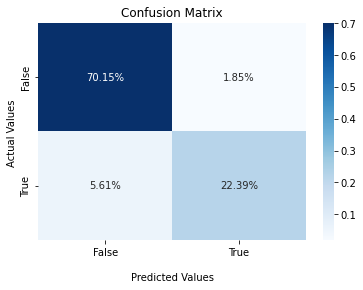

In [113]:
# Построим график «Матрица ошибок»
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## подписываем оси
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

In [114]:
precision = sklearn.metrics.precision_score(y_test, preds_cat_test_accuracy)
precision

0.9237536656891495

In [115]:
recall = sklearn.metrics.recall_score(y_test, preds_cat_test_accuracy)
recall

0.799492385786802

Построим график precision - recall

In [116]:
y_test_int = pd.Series(y_test).replace({'Good': 1, 'Bad': 0})

baseline_model = sum(y_test_int == 1) / len(y_test_int)

precision_cur, recall_cur, _ = precision_recall_curve(y_test_int, preds_cat_test_roc_auc)
auc_lr = auc(recall_cur, precision_cur)

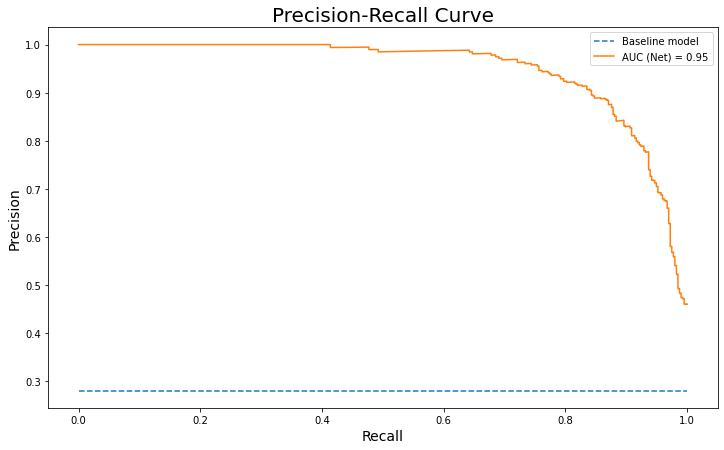

In [117]:
plt.figure(figsize=(12, 7))
plt.plot([0, 1], [baseline_model, baseline_model], linestyle='--', label='Baseline model')
plt.plot(recall_cur, precision_cur, label=f'AUC (Net) = {auc_lr:.2f}')

plt.title('Precision-Recall Curve', size=20)
plt.xlabel('Recall', size=14)
plt.ylabel('Precision', size=14)
plt.legend();

### Проанализируем важность основных факторов, влияющих на отток клиента.

In [118]:
# объединим признаки из тестовой и тренировочной выборок
df_imp = X_train_1.append(X_test_1)

In [119]:
# создадим контейнер Series из признаков и определим их важность
cat_imp = pd.Series(model_cat.get_feature_importance(), df_imp.columns)

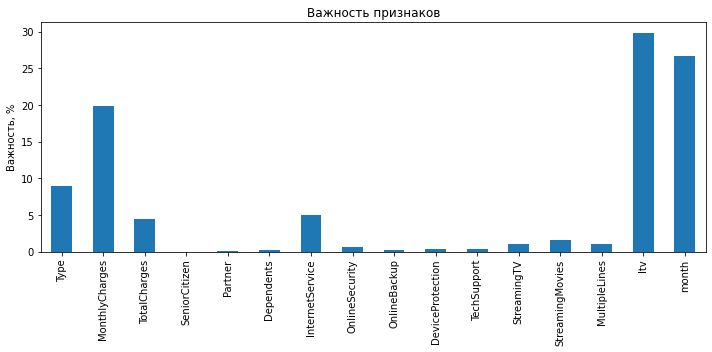

In [120]:
# визуализируем результат
fig, ax = plt.subplots(figsize=(10,5))
cat_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

In [121]:
cat_imp.sort_values(ascending=False)

ltv                 29.770068
month               26.701537
MonthlyCharges      19.827029
Type                 8.997856
InternetService      4.931068
TotalCharges         4.401785
StreamingMovies      1.507369
MultipleLines        1.026283
StreamingTV          1.023741
OnlineSecurity       0.622869
TechSupport          0.388522
DeviceProtection     0.292809
Dependents           0.253039
OnlineBackup         0.169918
Partner              0.086107
SeniorCitizen        0.000000
dtype: float64

Наиболее значимыми признаками стали LTV (дополнительно сгенерированный признак), месячные расходы клиентов, а также месяц и год, в которые клиенты подписали договор с компанией.

Месяц и год, вероятно, показали влияние на работу модели, так как часть клиентов оплачивали услуги на год или два вперед.

Важность расходов месячных и за все время пользования услугами, была подчеркнута еще на этапе исследовательского анализа. Теперь нами получено подтверждение этого вывода.

###  Построим график зависимости LTV и целевой переменной.

In [122]:
df_new = df_for_analys[['EndDate', 'ltv']]

In [123]:
df_new_0 = df_new[df_new['EndDate'] == 0]
df_new_1 = df_new[df_new['EndDate'] == 1]

In [124]:
df_new_0 = df_new_0.drop('EndDate', axis=1)
df_new_1 = df_new_1.drop('EndDate', axis=1)

In [125]:
df_new_Charges = pd.concat([df_new_0, df_new_1], axis=1) 

In [126]:
df_new_Charges.columns = ['gone_clients', 'current_clients']

In [127]:
df_new_Charges.describe()

,gone_clients,current_clients
count,5174.000000,1869.000000
mean,914.998531,767.561289
std,659.138103,331.989251
min,39.700000,77.000000
25%,470.400000,532.000000
50%,708.900000,764.500000
75%,1196.250000,990.600000
max,2850.000000,1890.500000


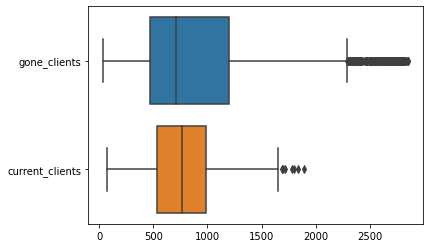

In [128]:
sns.boxplot(data=df_new_Charges, orient='h');

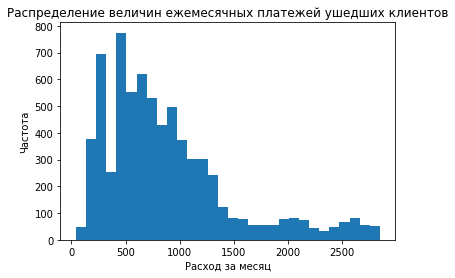

In [129]:
plt.hist(df_new.ltv, density=False, bins=30) 
plt.ylabel('Частота')
plt.xlabel('Расход за месяц')
plt.title('Распределение величин ежемесячных платежей ушедших клиентов');

**Вывод**

Анализ показывает, что клиенты начинают отказываться от услуг компании, при суммарных тратах более 2000 у.е. Компании при приближении трат клиента к данной сумме, стоит рассмотреть предоставление скидок, дополнительных бесплатных услуг или сервисов, бонусов.   